Text(0, 0.5, 'Log(L/L$_\\odot$)')

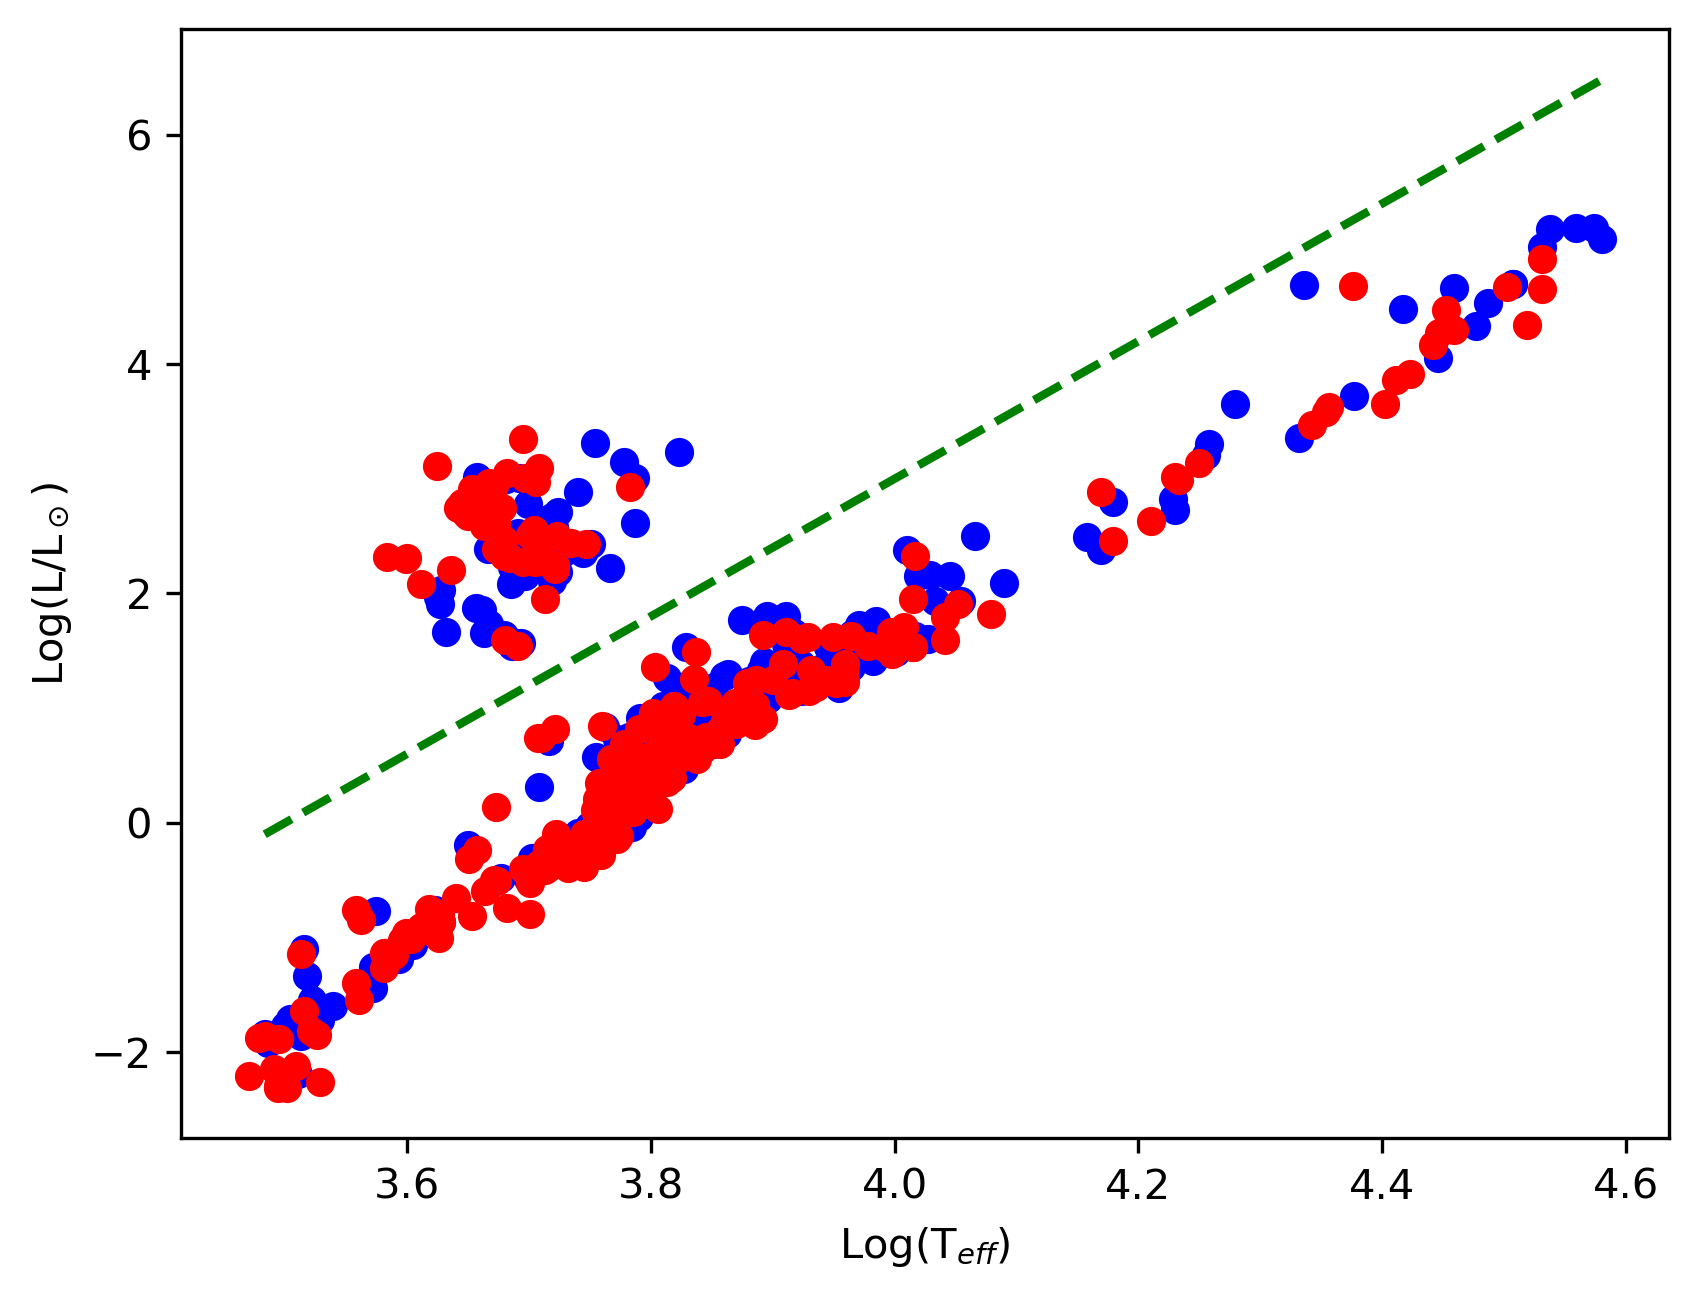

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import arviz as az

df = Table.read('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', format='ascii').to_pandas()

#filter out erroneous values
df = df[df['logL1'] > -3]

logT1 = df["logT1"]
logT1 = np.array(logT1)
logL1 = df["logL1"]
logL1 = np.array(logL1)

logT2 = df["logT2"]
logT2 = np.array(logT2)
logL2 = df["logL2"]
logL2 = np.array(logL2)

plt.scatter(logT1, logL1, color='blue')
plt.scatter(logT2, logL2, color='red')
plt.plot(logT1, 6*logT1 -21, color='green', linestyle='--', linewidth=2)
plt.xlabel('Log(T$_{eff}$)')
plt.ylabel('Log(L/L$_\odot$)')

In [89]:
import os

In [90]:
os.getcwd()

'/Users/sarahtaft/Astrostats'

In [65]:
#make the cut for red giant and main sequence for dataset 1
logR1_ms = df['logR1'][logL1 < (6*logT1-21)]
logR1_rg = df['logR1'][logL1 > (6*logT1-21)]

#make the cut for red giant and main sequence for dataset 2
logR2_ms = df['logR2'][logL1 < (6*logT1-21)]
logR2_rg = df['logR2'][logL1 > (6*logT1-21)]

#filter the errors for dataset 1
logR1_ms_err = df['logR1e'][logL1 < (6*logT1-21)]
logR1_rg_err = df['logR1e'][logL1 > (6*logT1-21)]

#filter the erros for dataset 2
logR2_ms_err = df['logR2e'][logL1 < (6*logT1-21)]
logR2_rg_err = df['logR2e'][logL1 > (6*logT1-21)]

#convert all data to numpy arrays
logR1_ms = np.array(logR1_ms)
logR1_rg = np.array(logR1_rg)
logR2_ms = np.array(logR2_ms)
logR2_rg = np.array(logR2_rg)

#convert all errors to numpy arrays
logR1_ms_err = np.array(logR1_ms_err)
logR1_rg_err = np.array(logR1_rg_err)
logR2_ms_err = np.array(logR2_ms_err)
logR2_rg_err = np.array(logR2_rg_err)

#concatenate all radii data into one array
radii_all = np.concatenate((logR1_ms, logR1_rg, logR2_ms, logR2_rg))

#concatenate all radius error data into one array
radii_all_err = np.concatenate((logR1_ms_err, logR1_rg_err, logR2_ms_err, logR2_rg_err))

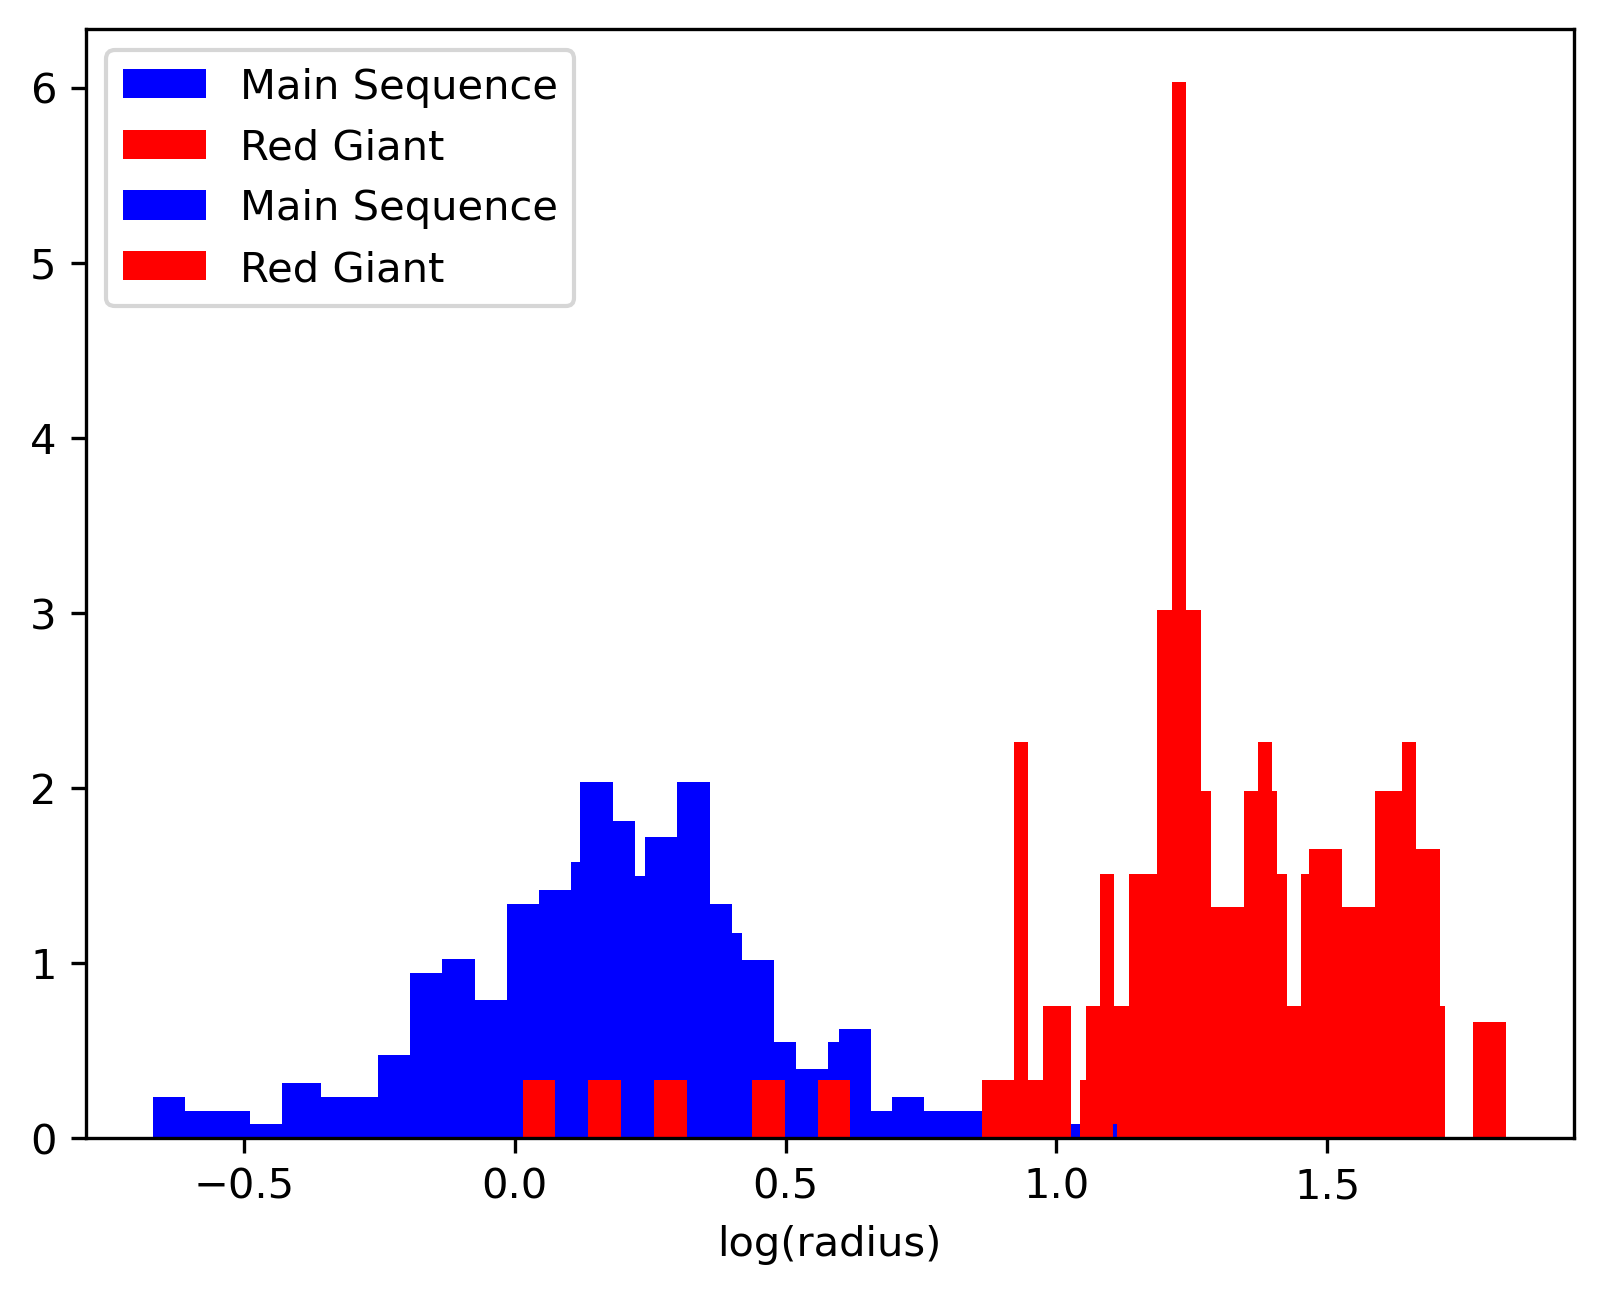

In [66]:
plt.hist(logR1_ms, color='blue', density=True, label='Main Sequence', bins=30)
plt.hist(logR1_rg, color='red', density=True, label='Red Giant', bins=30)
plt.hist(logR2_ms, color='blue', density=True, label='Main Sequence', bins=30)
plt.hist(logR2_rg, color='red', density=True, label='Red Giant', bins=30)
plt.xlabel('log(radius)')
plt.legend()

Text(0.5, 0, 'log(radius)')

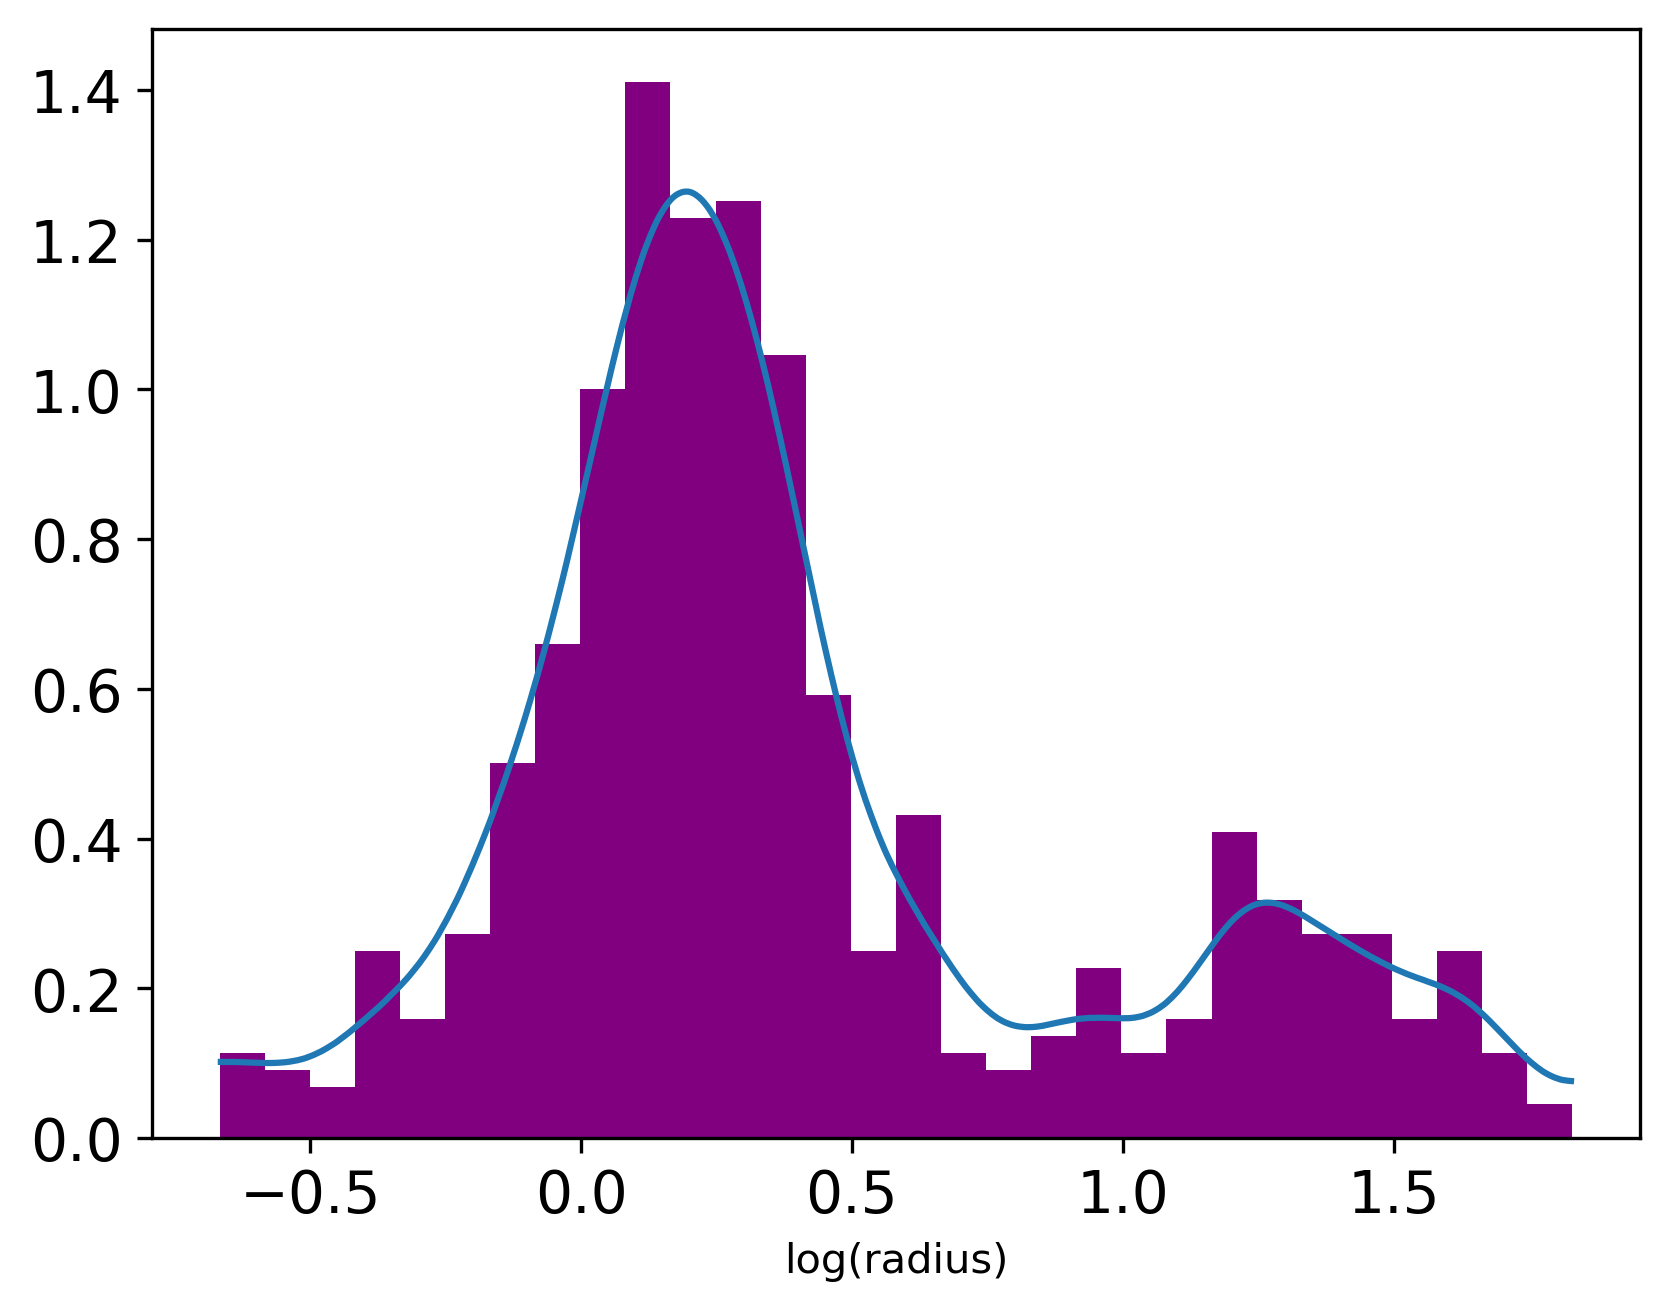

In [67]:
plt.hist(radii_all, color='purple', density=True, bins=30)
az.plot_kde(radii_all)
plt.xlabel('log(radius)')

## Analysis:

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

## Start with k=3:

In [112]:
k=3

with pm.Model() as mixture:
    w = pm.Dirichlet('w',a=np.ones(k))
    means = pm.Normal('means1',mu=[0.,1,2],tau=1e-3,shape=(3,))
    tau = pm.Gamma('tau',alpha=0.5, beta=0.5,shape=(3,))
    components = pm.Normal.dist(mu=means,tau=tau, shape=(3,))


    y = pm.Mixture('y', w=w, comp_dists=components, observed=radii_all)

    trace_out = pm.sample(5000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, means1, tau]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 71 seconds.


array([[<AxesSubplot: title={'center': 'means1'}>,
        <AxesSubplot: title={'center': 'means1'}>],
       [<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>],
       [<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

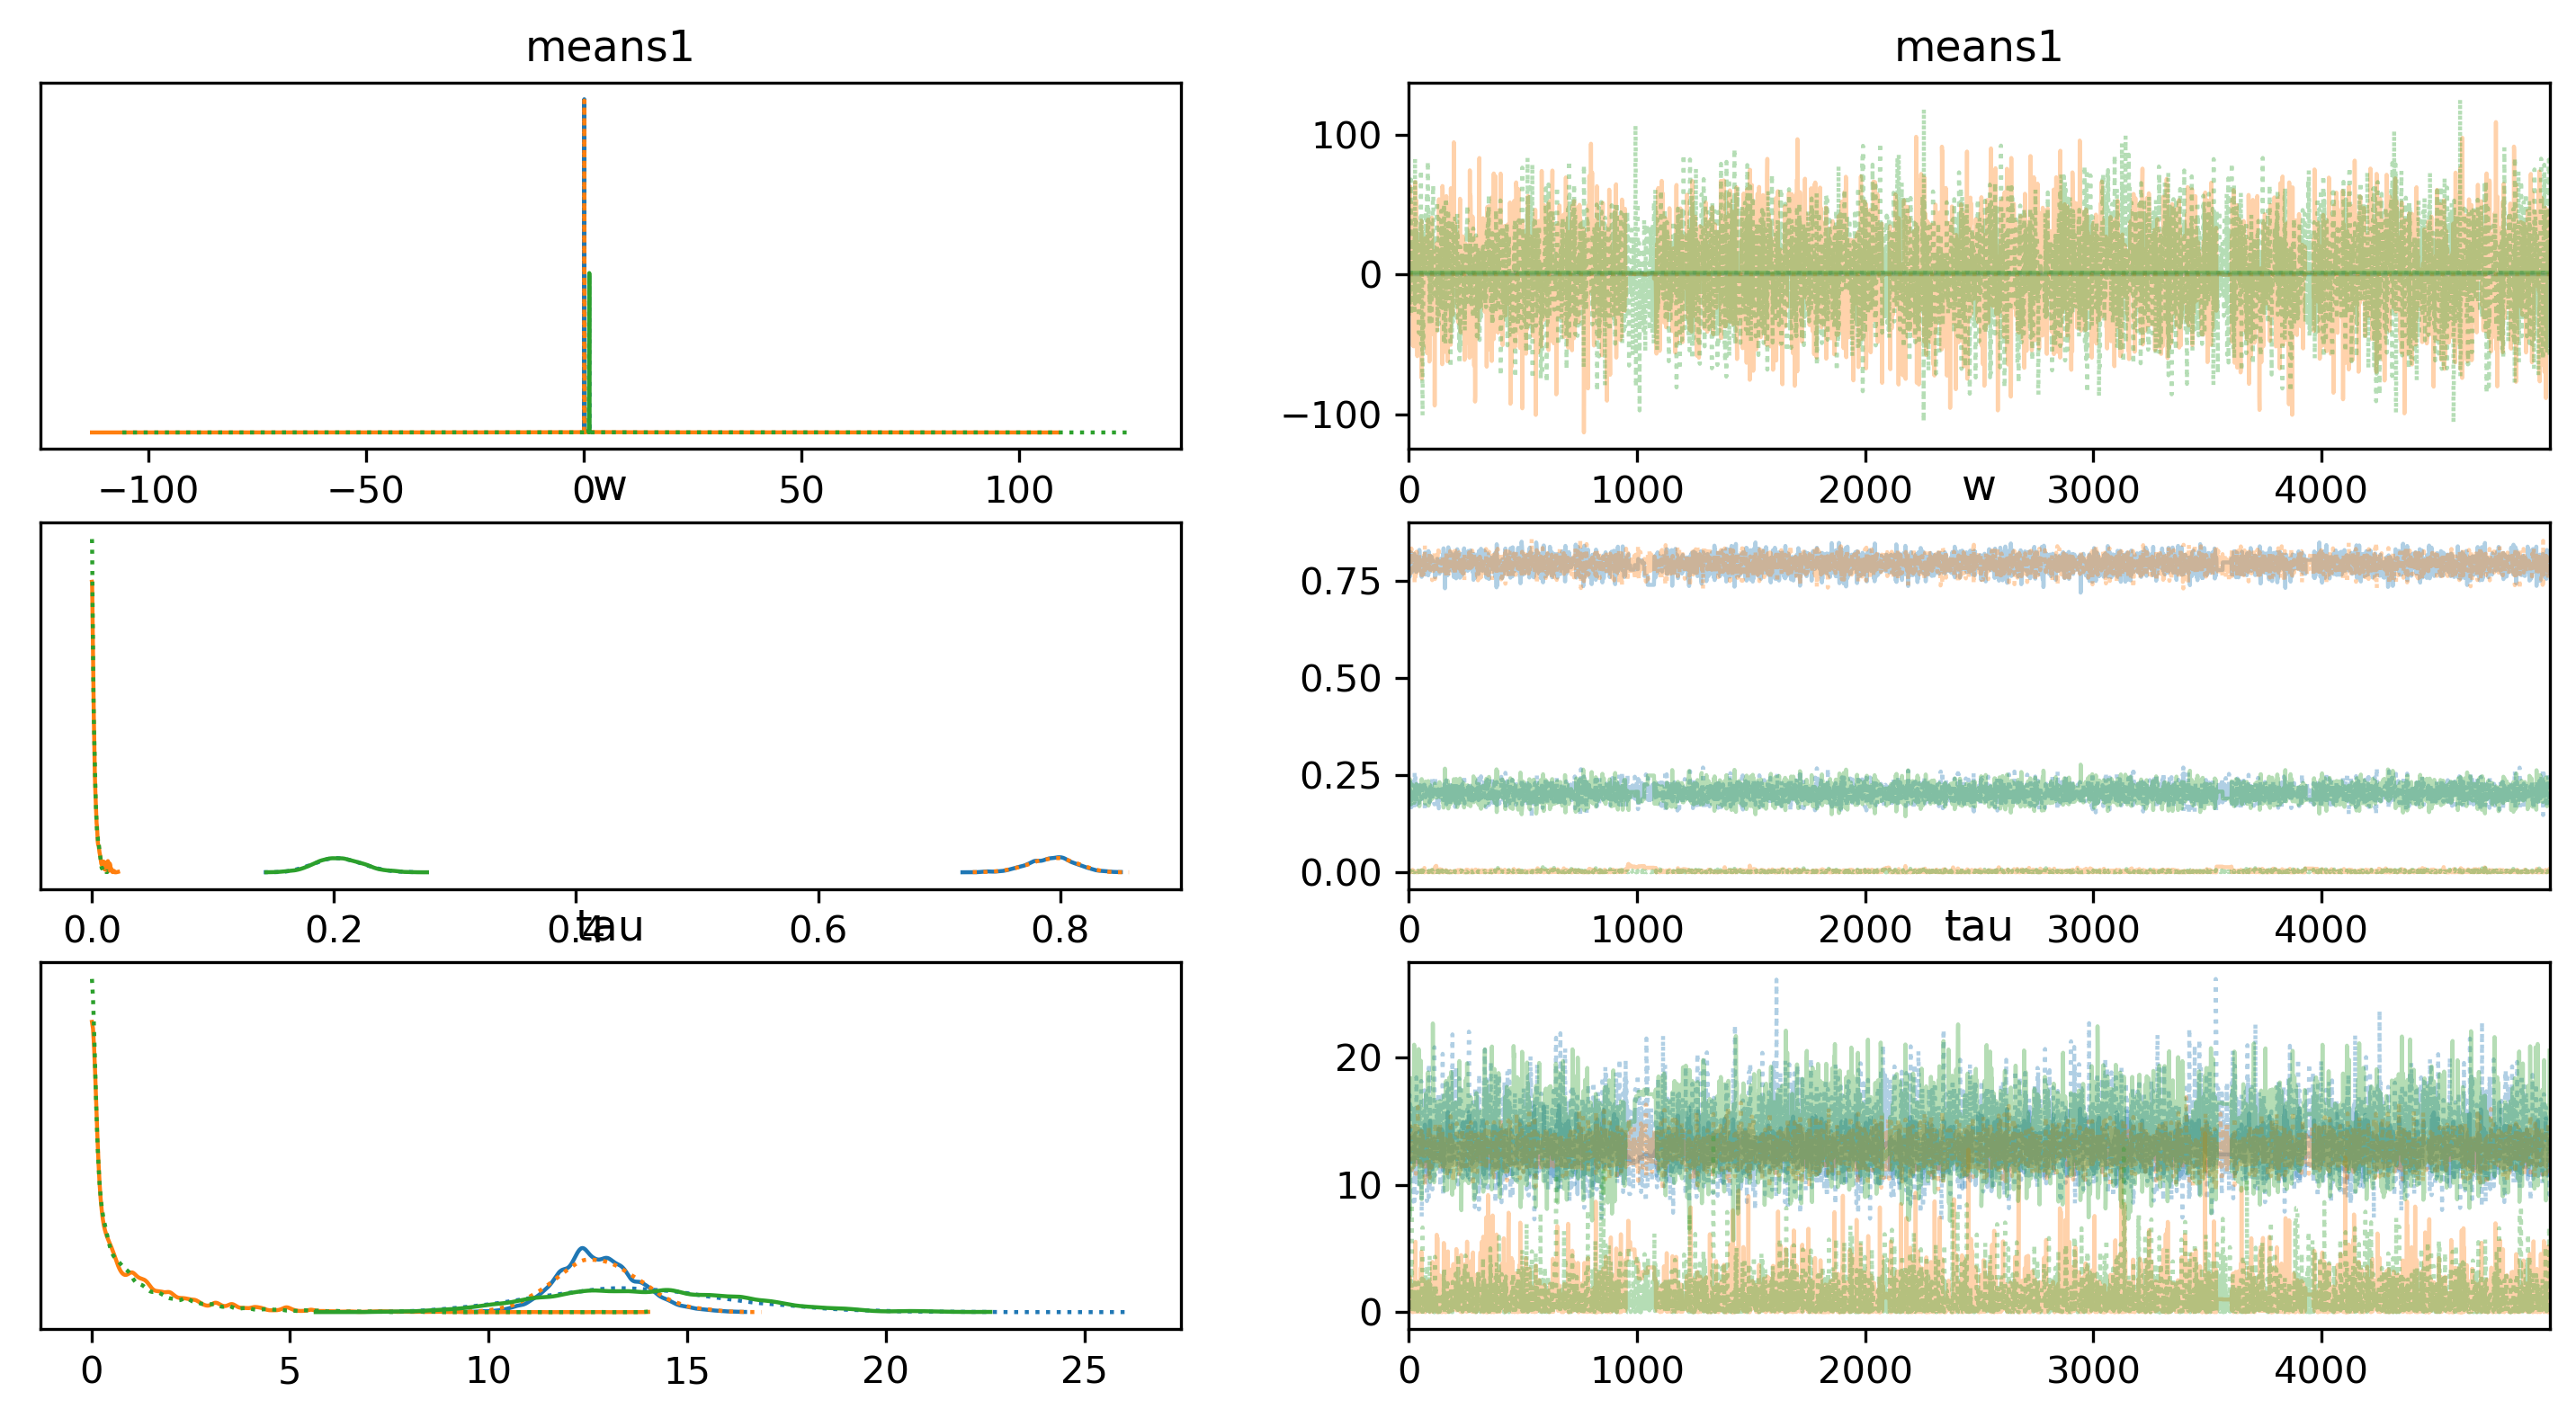

In [113]:
az.plot_trace(trace_out)

In [114]:
az.summary(trace_out)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means1[0]   0.738   0.567   0.143    1.347      0.400    0.339       3.0   
means1[1]   0.445  20.684 -46.485   46.735      0.268    4.701    5187.0   
means1[2]   1.947  21.438 -44.423   50.173      0.283    5.032    5707.0   
w[0]        0.499   0.295   0.173    0.820      0.208    0.176       3.0   
w[1]        0.398   0.396   0.000    0.816      0.279    0.237       3.0   
w[2]        0.103   0.102   0.000    0.227      0.072    0.061       3.0   
tau[0]     13.237   1.935   9.793   17.365      0.335    0.273      58.0   
tau[1]      6.916   5.958   0.000   13.997      4.136    3.477       3.0   
tau[2]      7.456   6.783   0.000   16.929      4.623    3.856       3.0   

           ess_tail  r_hat  
means1[0]      52.0   1.83  
means1[1]      47.0   1.81  
means1[2]      44.0   1.82  
w[0]           47.0   1.83  
w[1]           50.0   1.83  
w[2]           53.0   1.83  
tau[0]         62.0   1.13  
tau[1]         52.0   1.82  
tau[2]         52.0   1.82

In [115]:
trace_out

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot: title={'center': 'w\n0'}>,
        <AxesSubplot: title={'center': 'w\n0'}>],
       [<AxesSubplot: title={'center': 'w\n1'}>,
        <AxesSubplot: title={'center': 'w\n1'}>],
       [<AxesSubplot: title={'center': 'w\n2'}>,
        <AxesSubplot: title={'center': 'w\n2'}>]], dtype=object)

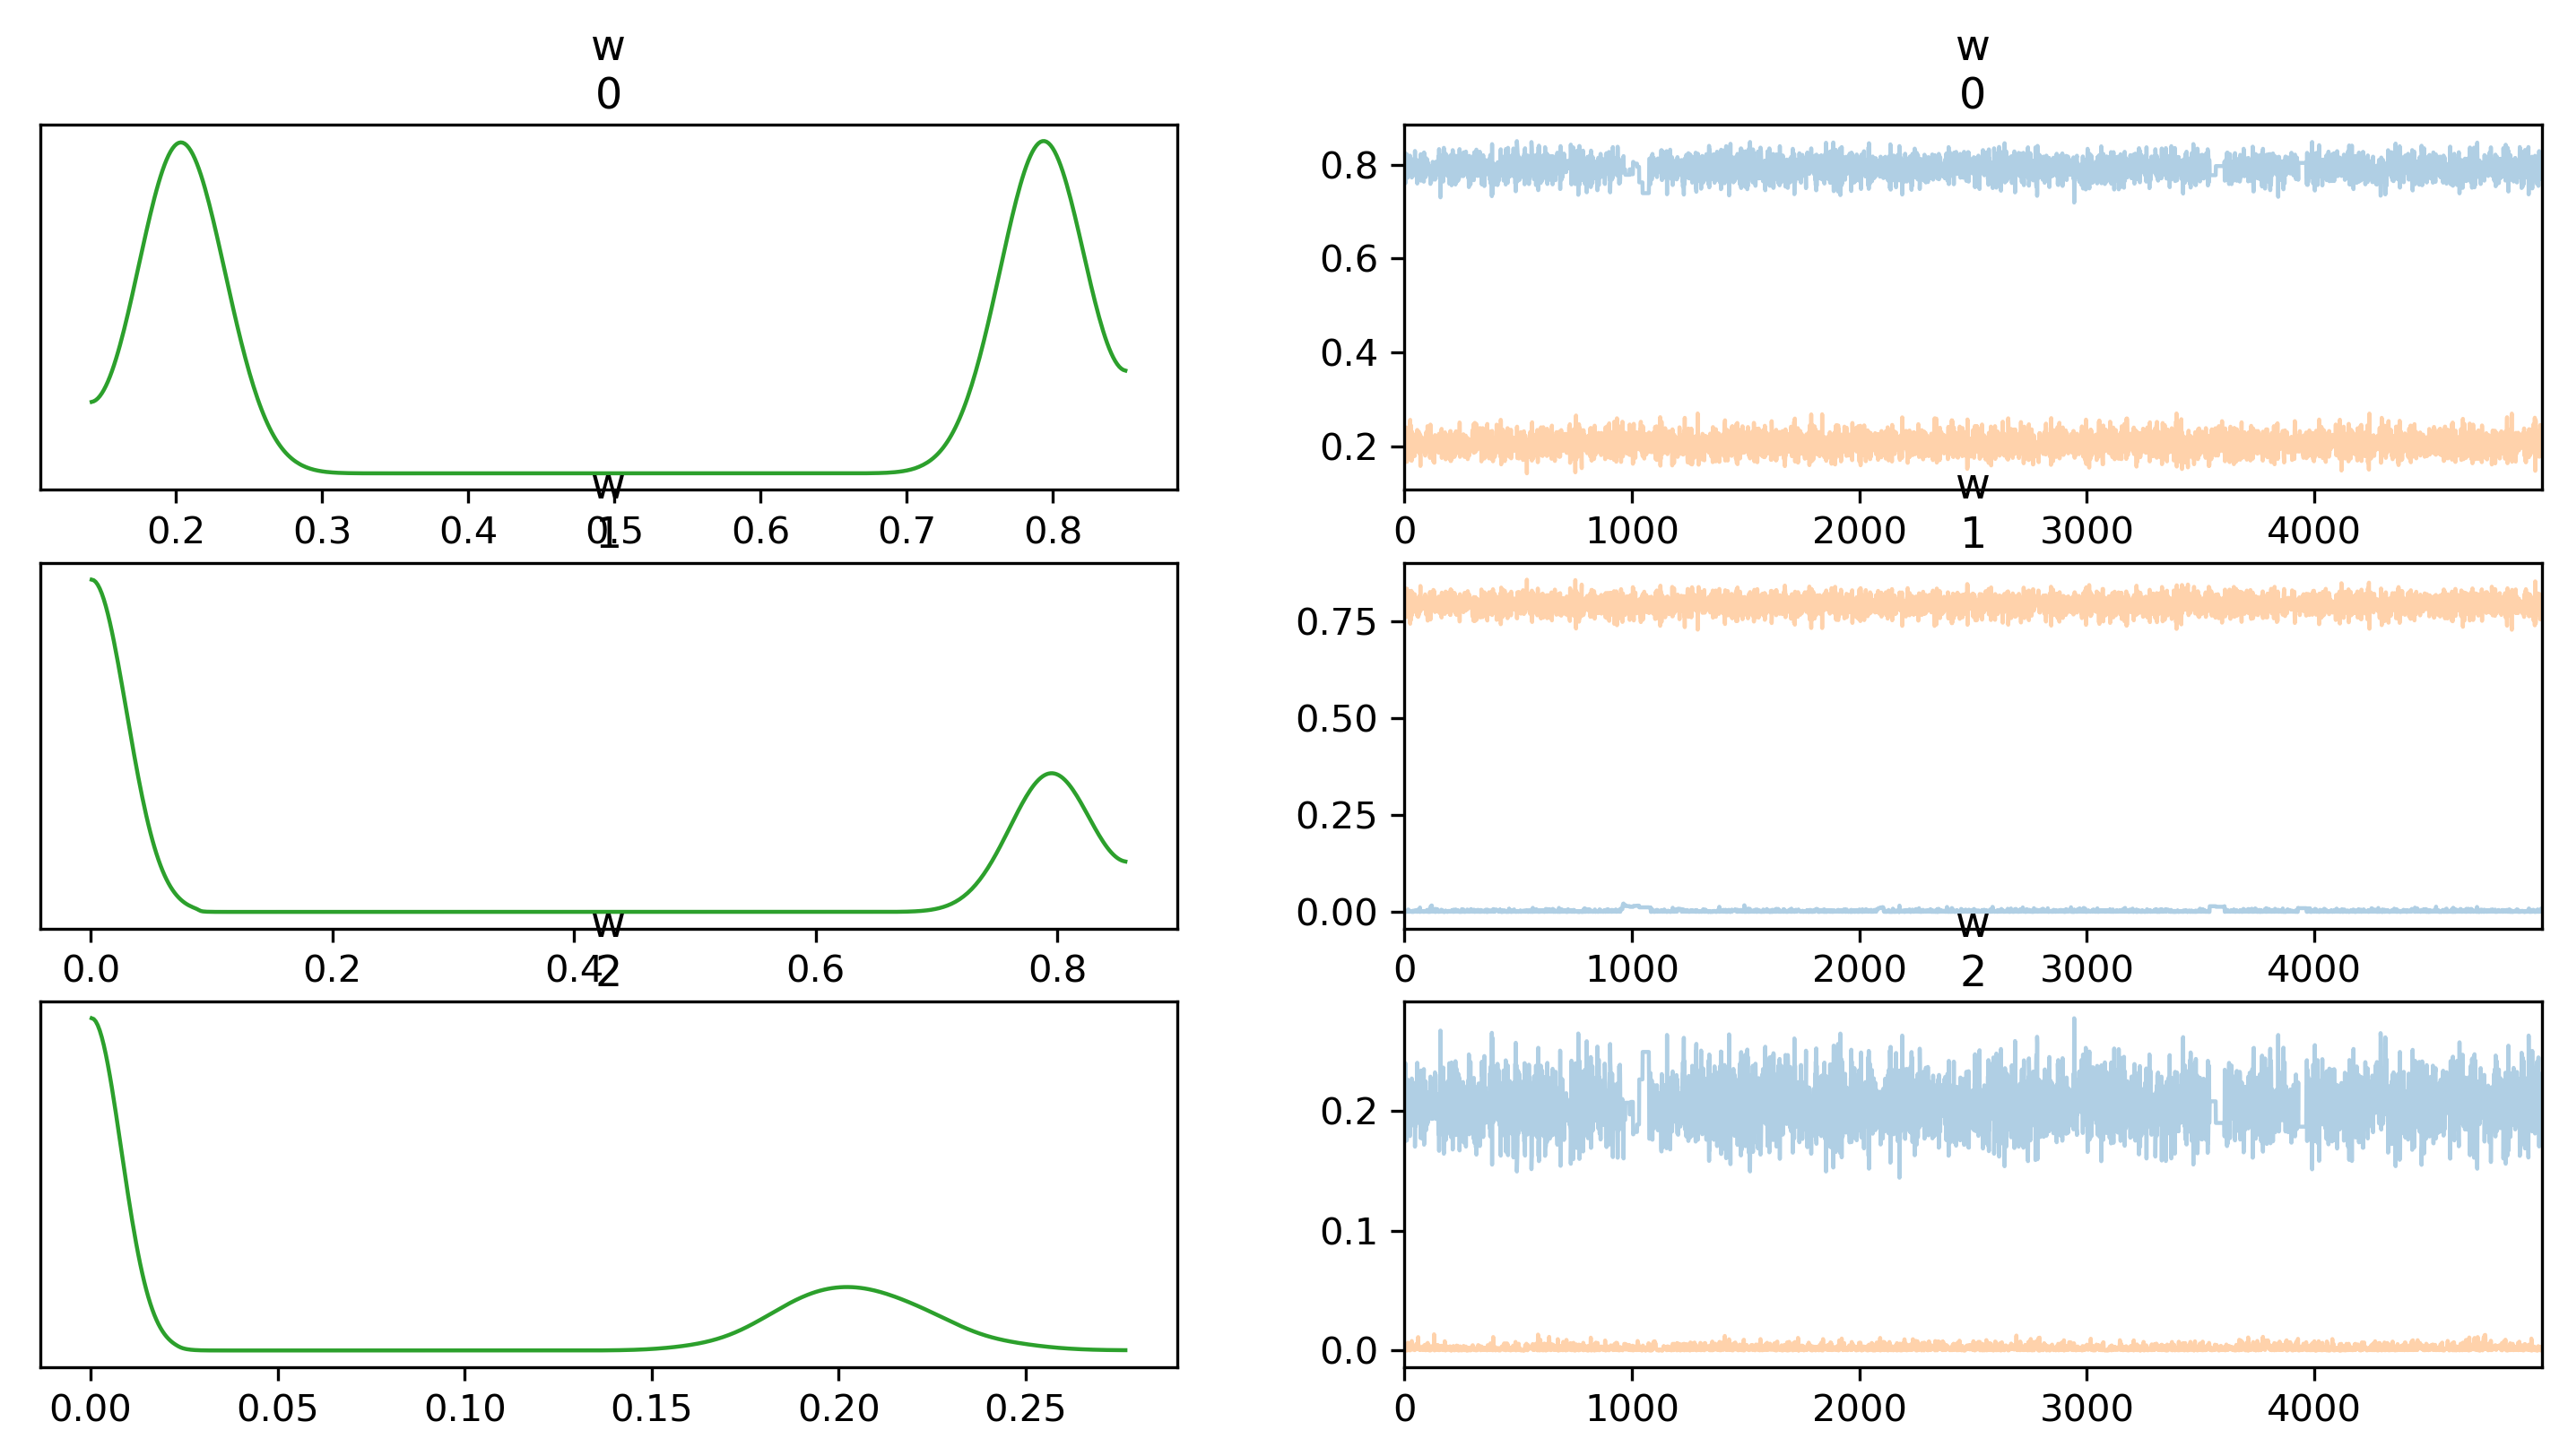

In [116]:
az.plot_trace(trace_out,['w'],combined=True,compact=False)

In [117]:
trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
print(len(trace_out.posterior['means1'].to_numpy()))

2


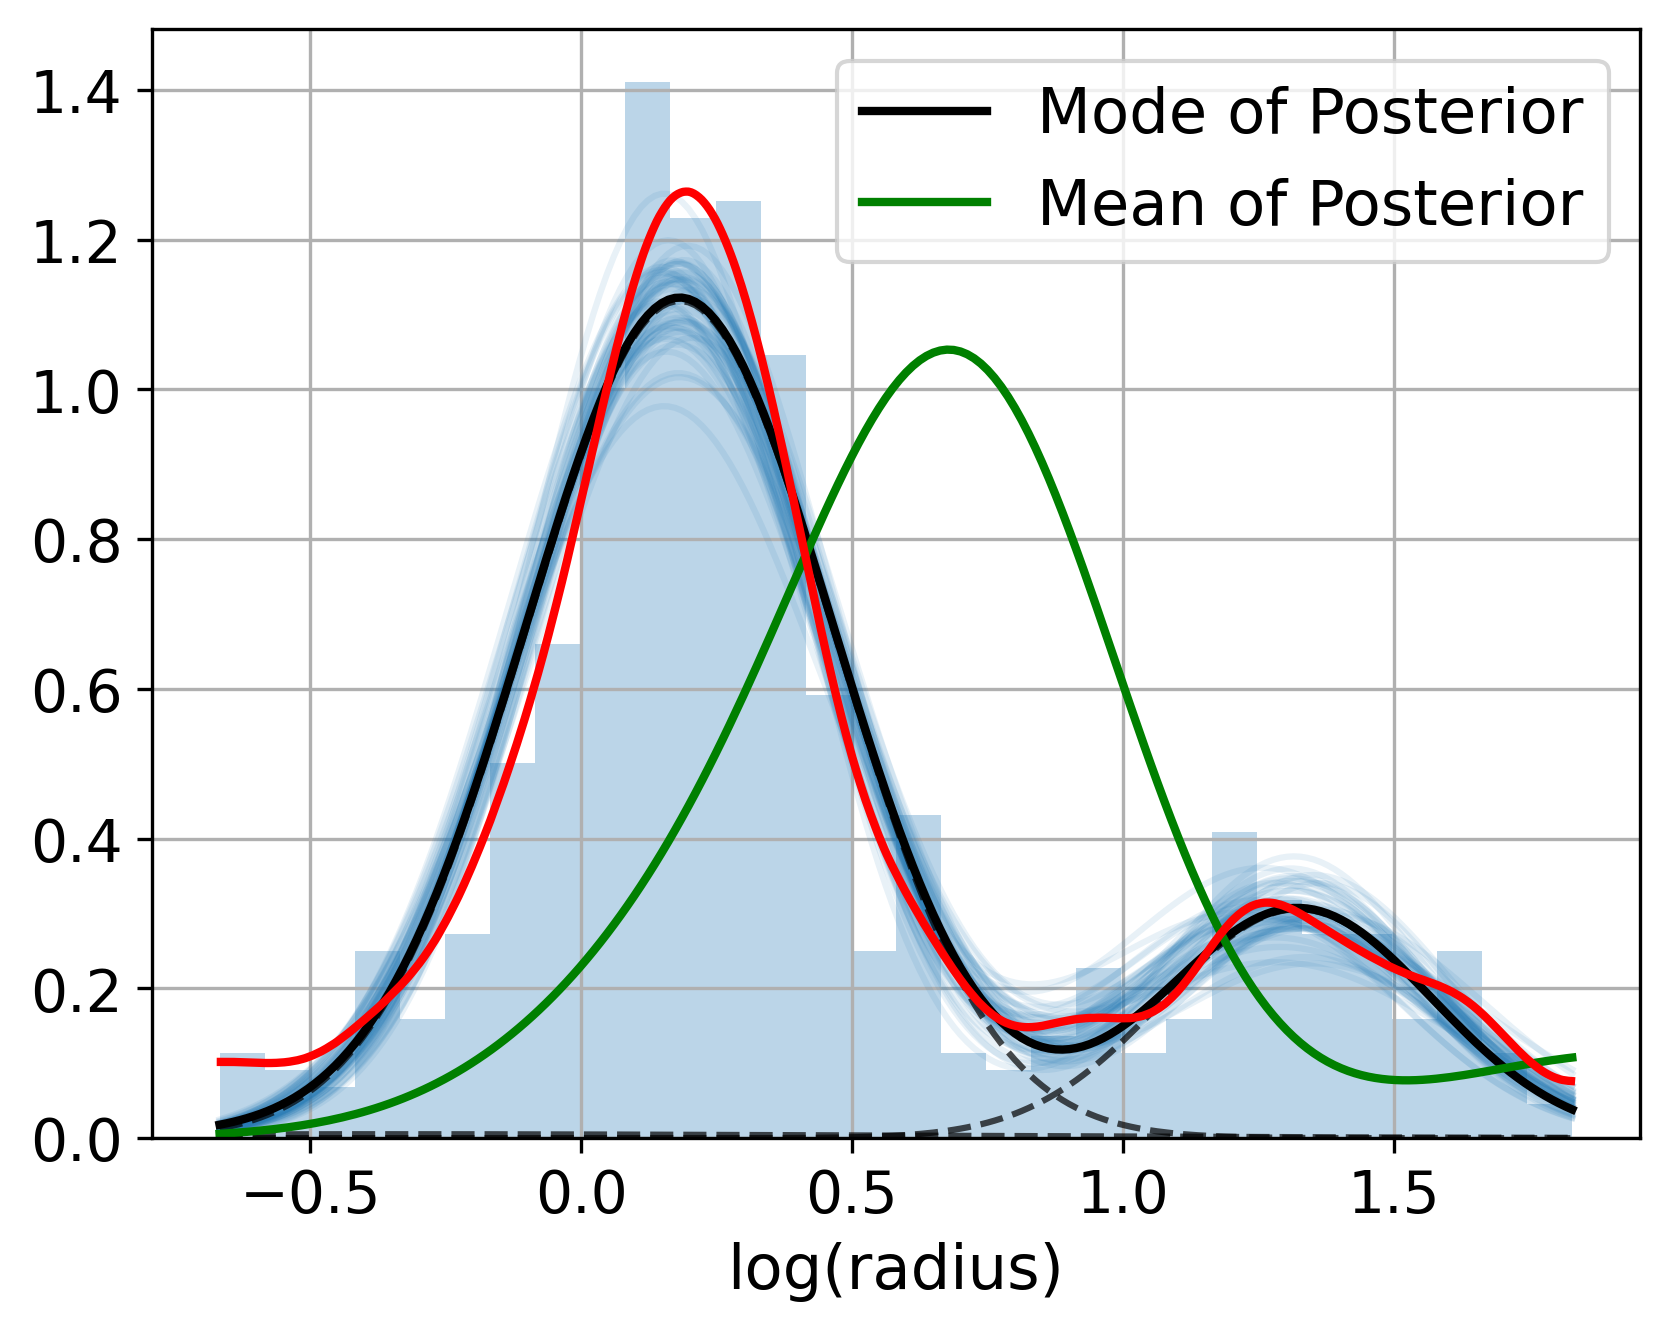

In [118]:
import random
from scipy import stats as st
x = np.linspace(radii_all.min(),radii_all.max(),200)

x_ = np.array([x]*3).T

for i in  range(50):
    i_ = np.random.randint(0,5000)
    means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    dist = stats.norm(means_y,1/np.sqrt(tau_y))
    plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'C0',alpha=0.1)


med_y = st.mode(trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medw_y = st.mode(trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medt_y = st.mode(trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()

dist = stats.norm(med_y,1/np.sqrt(medt_y))
plt.plot(x,np.sum(dist.pdf(x_)*medw_y,1),'k',lw=2,label='Mode of Posterior')
plt.plot(x,dist.pdf(x_)*medw_y,'k--',alpha=0.7)

means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy().mean(1)
tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy().mean(1)
dist = stats.norm(means_y,1/np.sqrt(tau_y))
plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'g',lw=2,label='Mean of Posterior')





az.plot_kde(radii_all,plot_kwargs={'linewidth':2,'color':'r'})
plt.hist(radii_all,bins=30,density = True,alpha = 0.3)
plt.xlabel('log(radius)',fontsize=15)
plt.grid()
plt.legend(fontsize=15)



## Now try analysis for k=2:

In [119]:
k=2

with pm.Model() as mixture:
    w = pm.Dirichlet('w',a=np.ones(k))
    means = pm.Normal('means1',mu=[0.,1,],tau=1e-3,shape=(2,))
    tau = pm.Gamma('tau',alpha=0.5, beta=0.5,shape=(2,))
    components = pm.Normal.dist(mu=means,tau=tau, shape=(2,))


    y = pm.Mixture('y', w=w, comp_dists=components, observed=radii_all)

    trace_out = pm.sample(5000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, means1, tau]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 28 seconds.


array([[<AxesSubplot: title={'center': 'means1'}>,
        <AxesSubplot: title={'center': 'means1'}>],
       [<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>],
       [<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

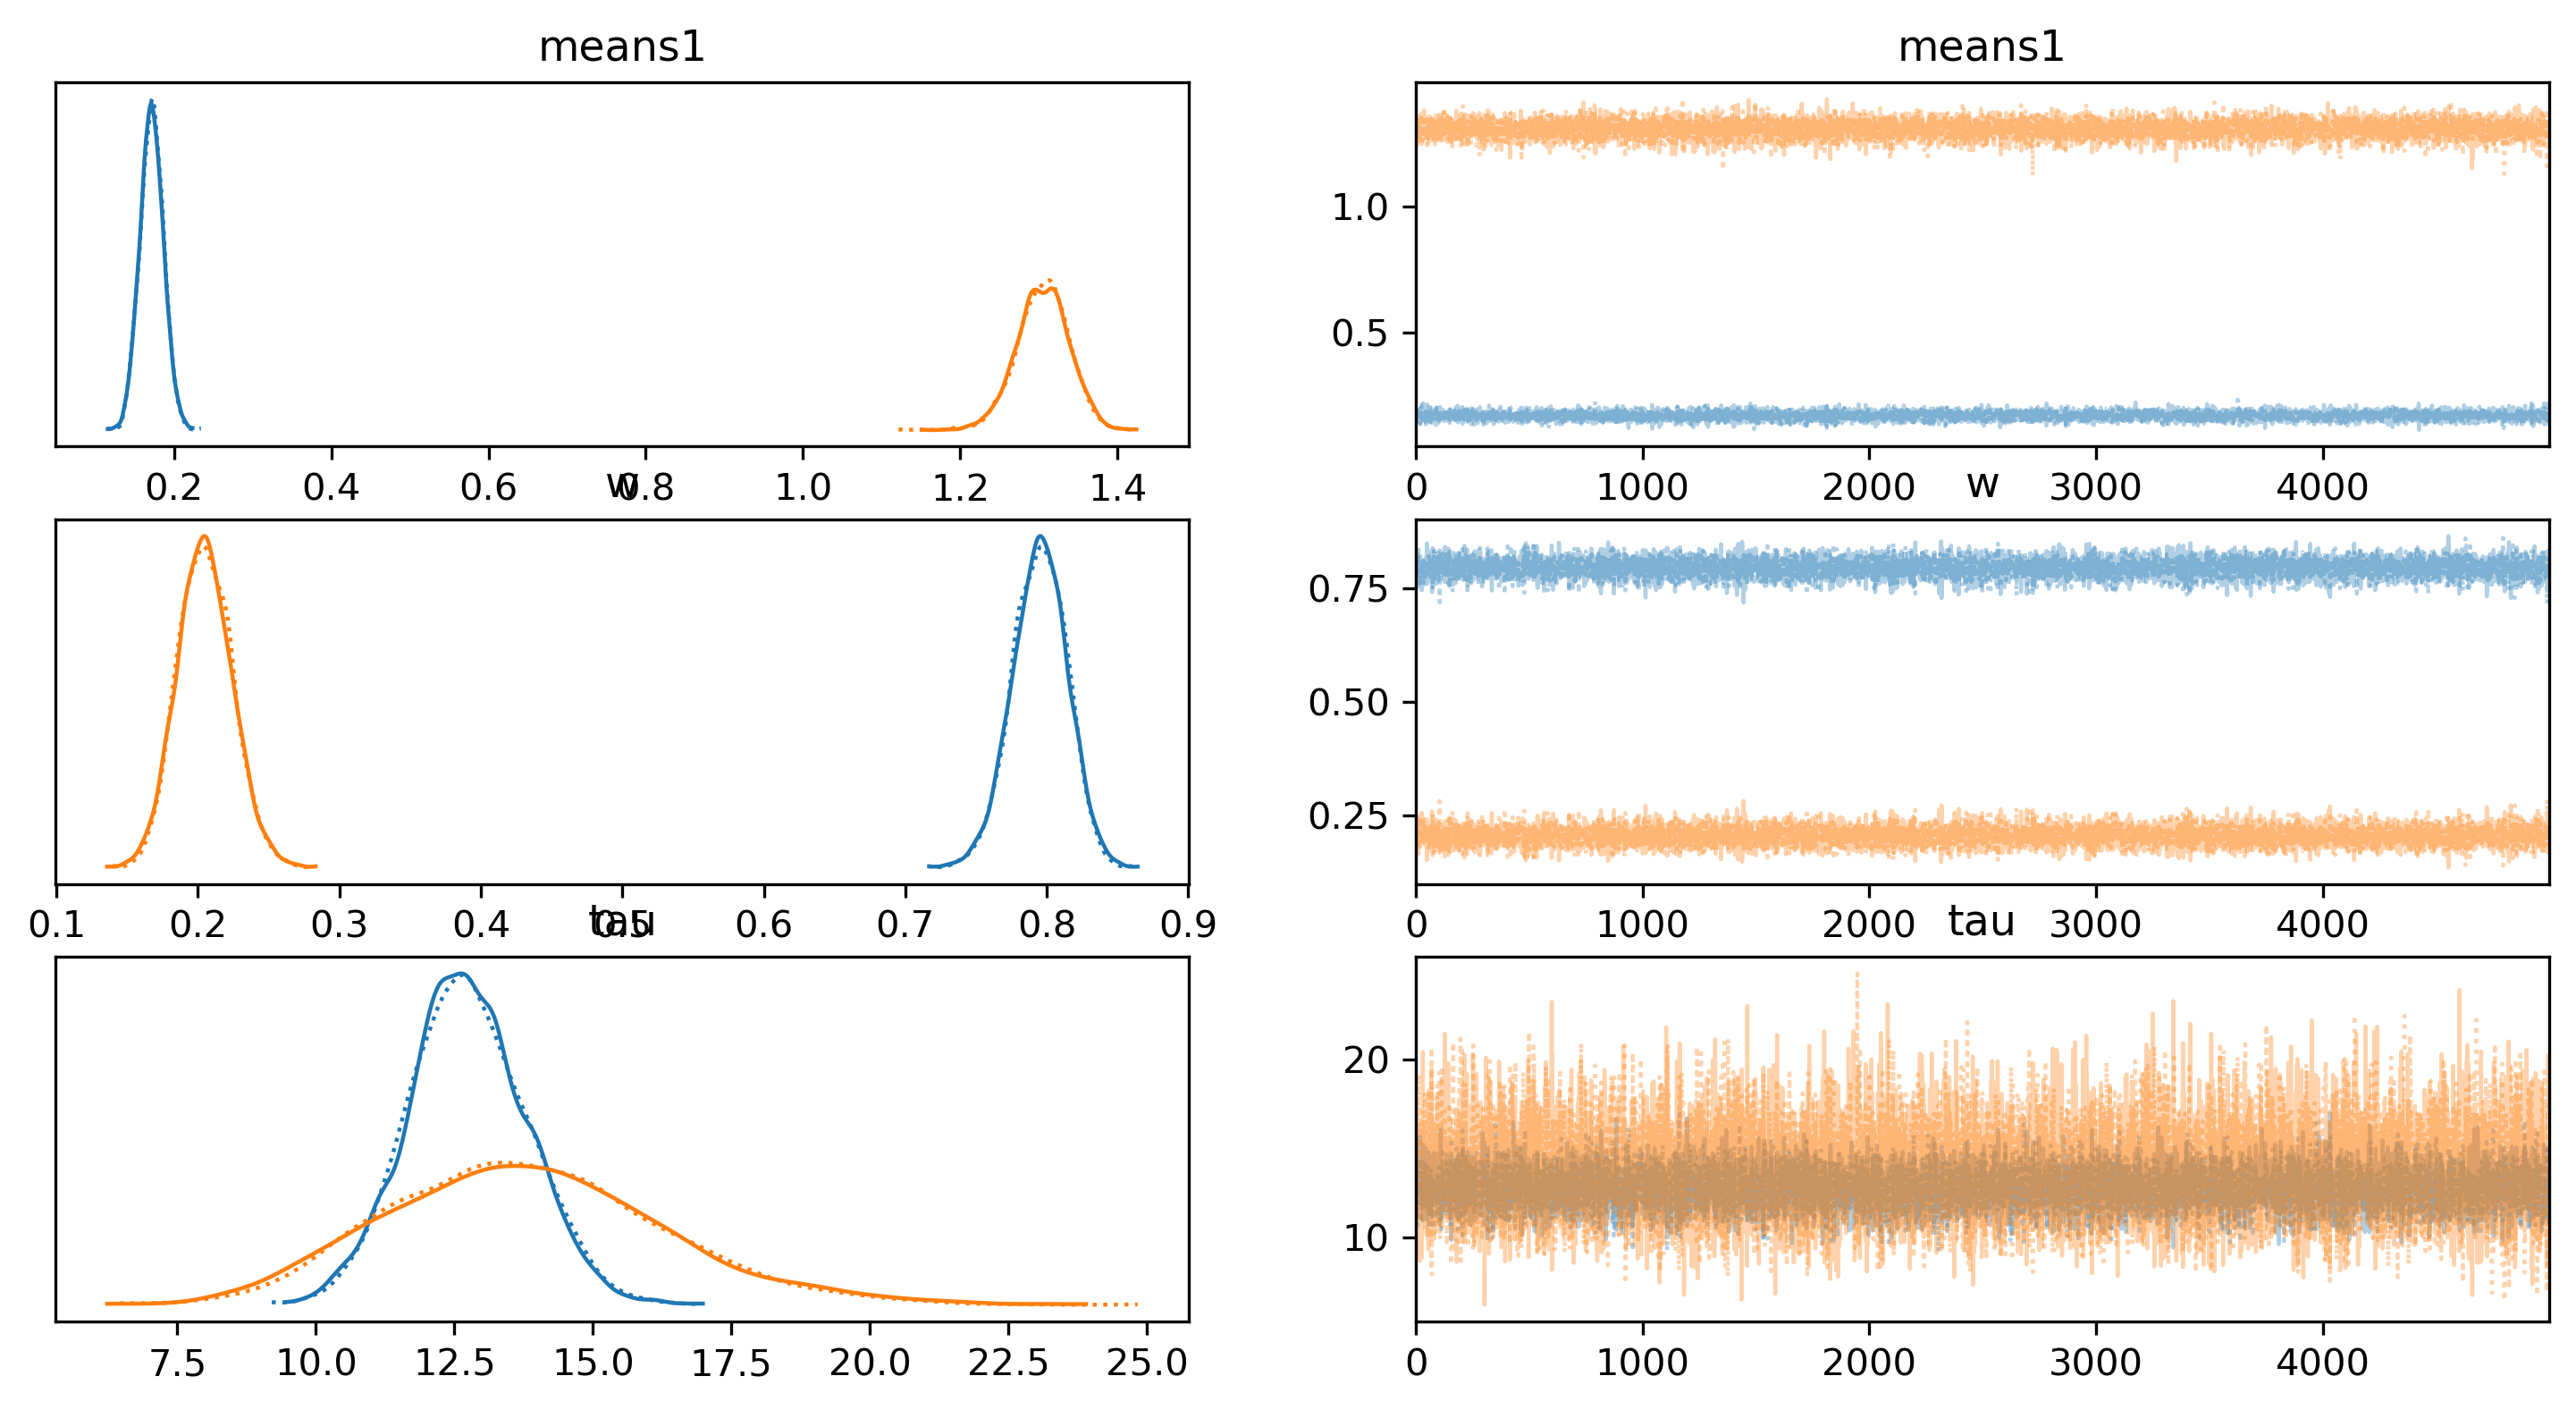

In [120]:
az.plot_trace(trace_out)

In [121]:
az.summary(trace_out)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means1[0]   0.172  0.015   0.143    0.199      0.000     0.00    7774.0   
means1[1]   1.305  0.033   1.243    1.367      0.000     0.00    7709.0   
w[0]        0.795  0.019   0.761    0.833      0.000     0.00    7929.0   
w[1]        0.205  0.019   0.167    0.239      0.000     0.00    7929.0   
tau[0]     12.739  1.068  10.783   14.787      0.013     0.01    6279.0   
tau[1]     13.748  2.475   8.968   18.179      0.028     0.02    7551.0   

           ess_tail  r_hat  
means1[0]    7243.0    1.0  
means1[1]    7249.0    1.0  
w[0]         7865.0    1.0  
w[1]         7865.0    1.0  
tau[0]       6840.0    1.0  
tau[1]       7751.0    1.0

In [122]:
trace_out

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot: title={'center': 'w\n0'}>,
        <AxesSubplot: title={'center': 'w\n0'}>],
       [<AxesSubplot: title={'center': 'w\n1'}>,
        <AxesSubplot: title={'center': 'w\n1'}>]], dtype=object)

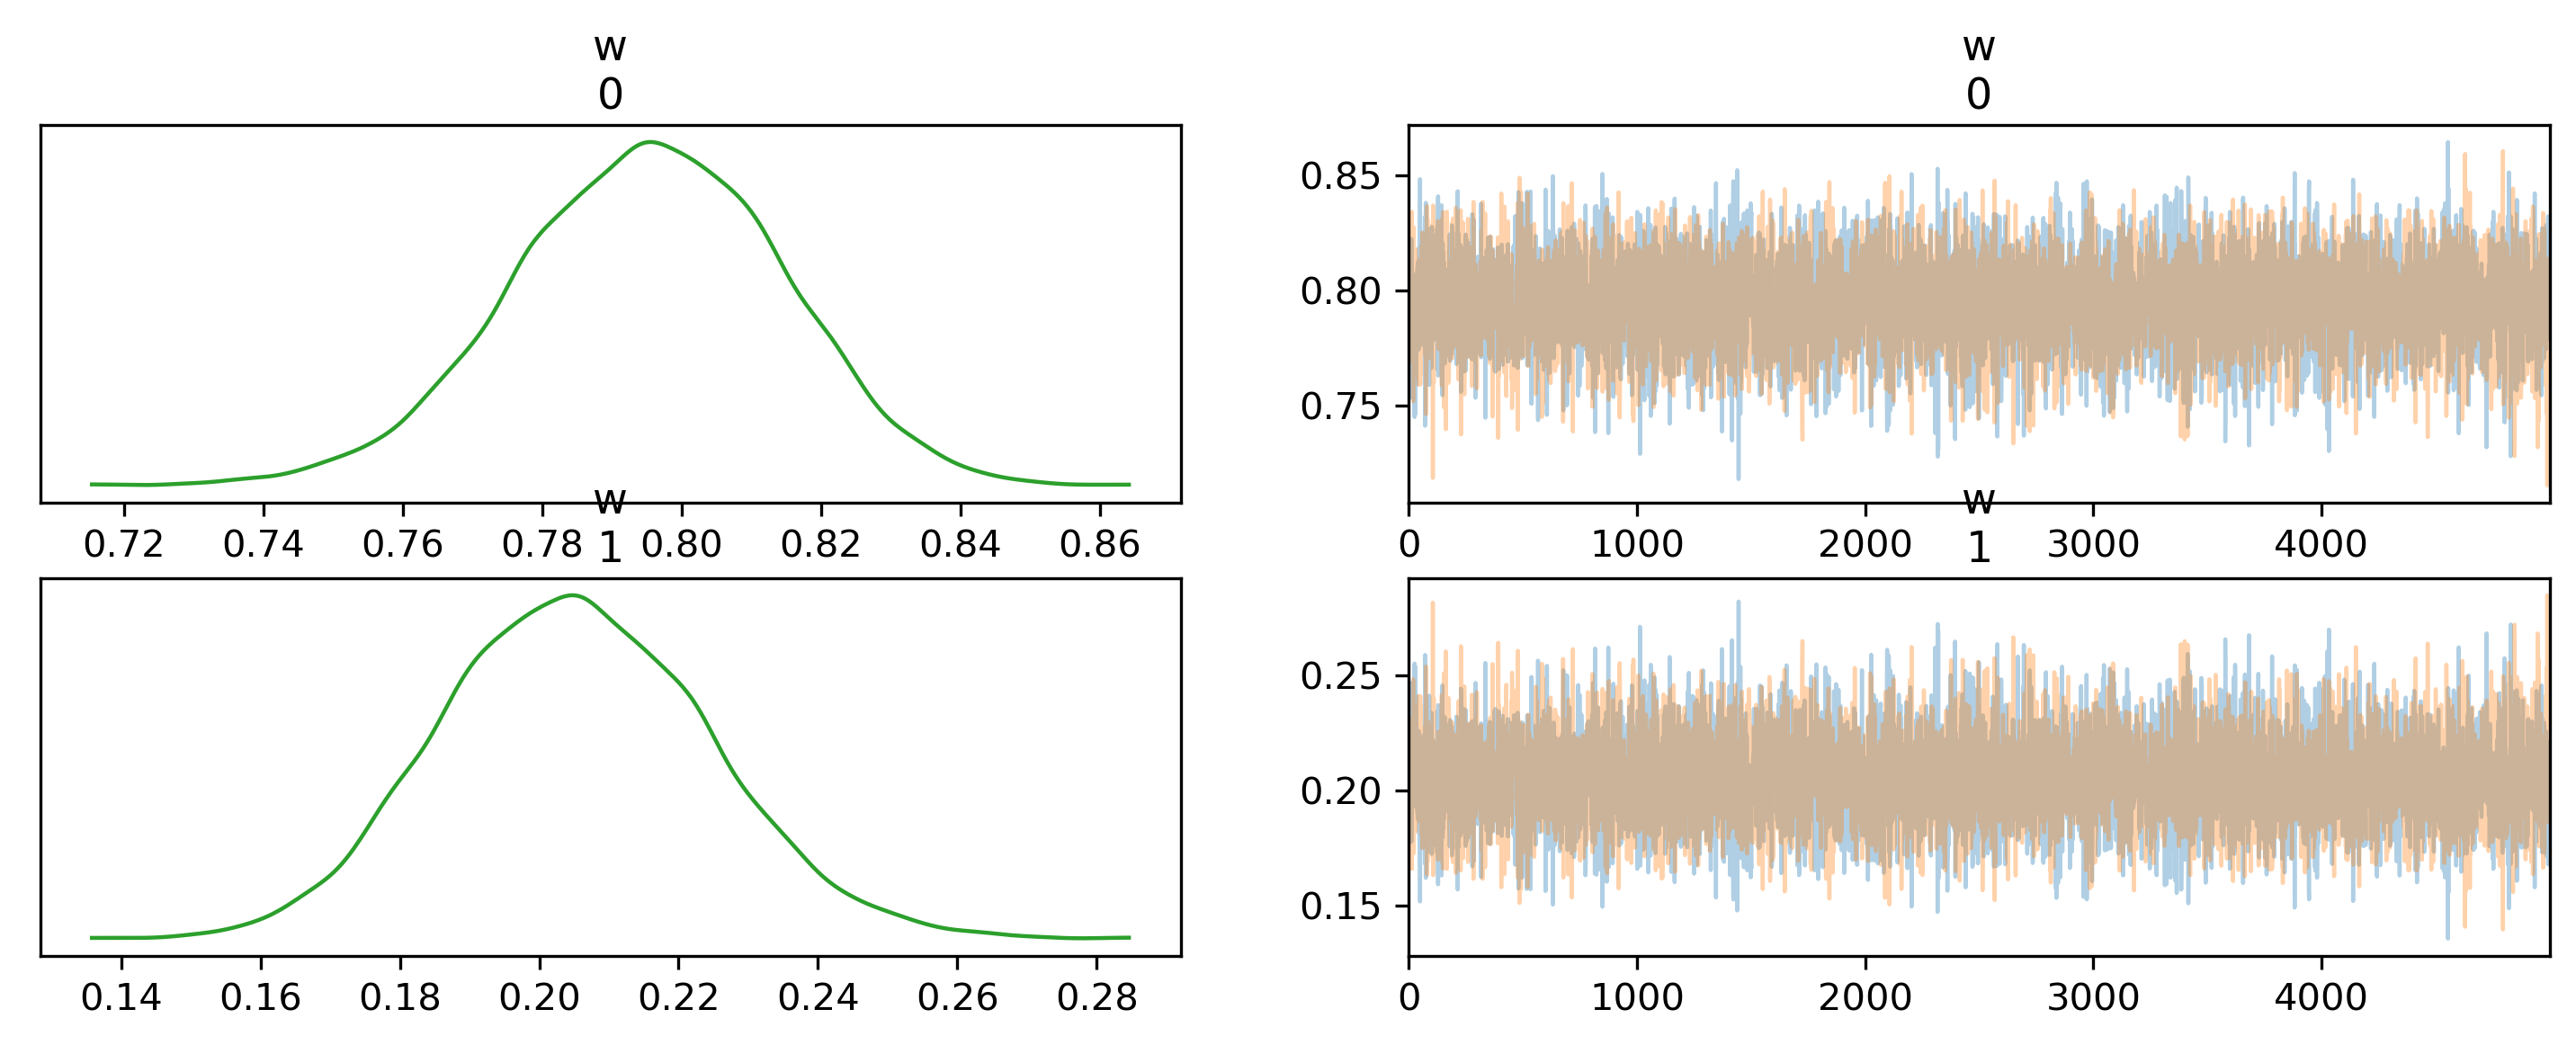

In [123]:
az.plot_trace(trace_out,['w'],combined=True,compact=False)

In [124]:
trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
print(len(trace_out.posterior['means1'].to_numpy()))

2


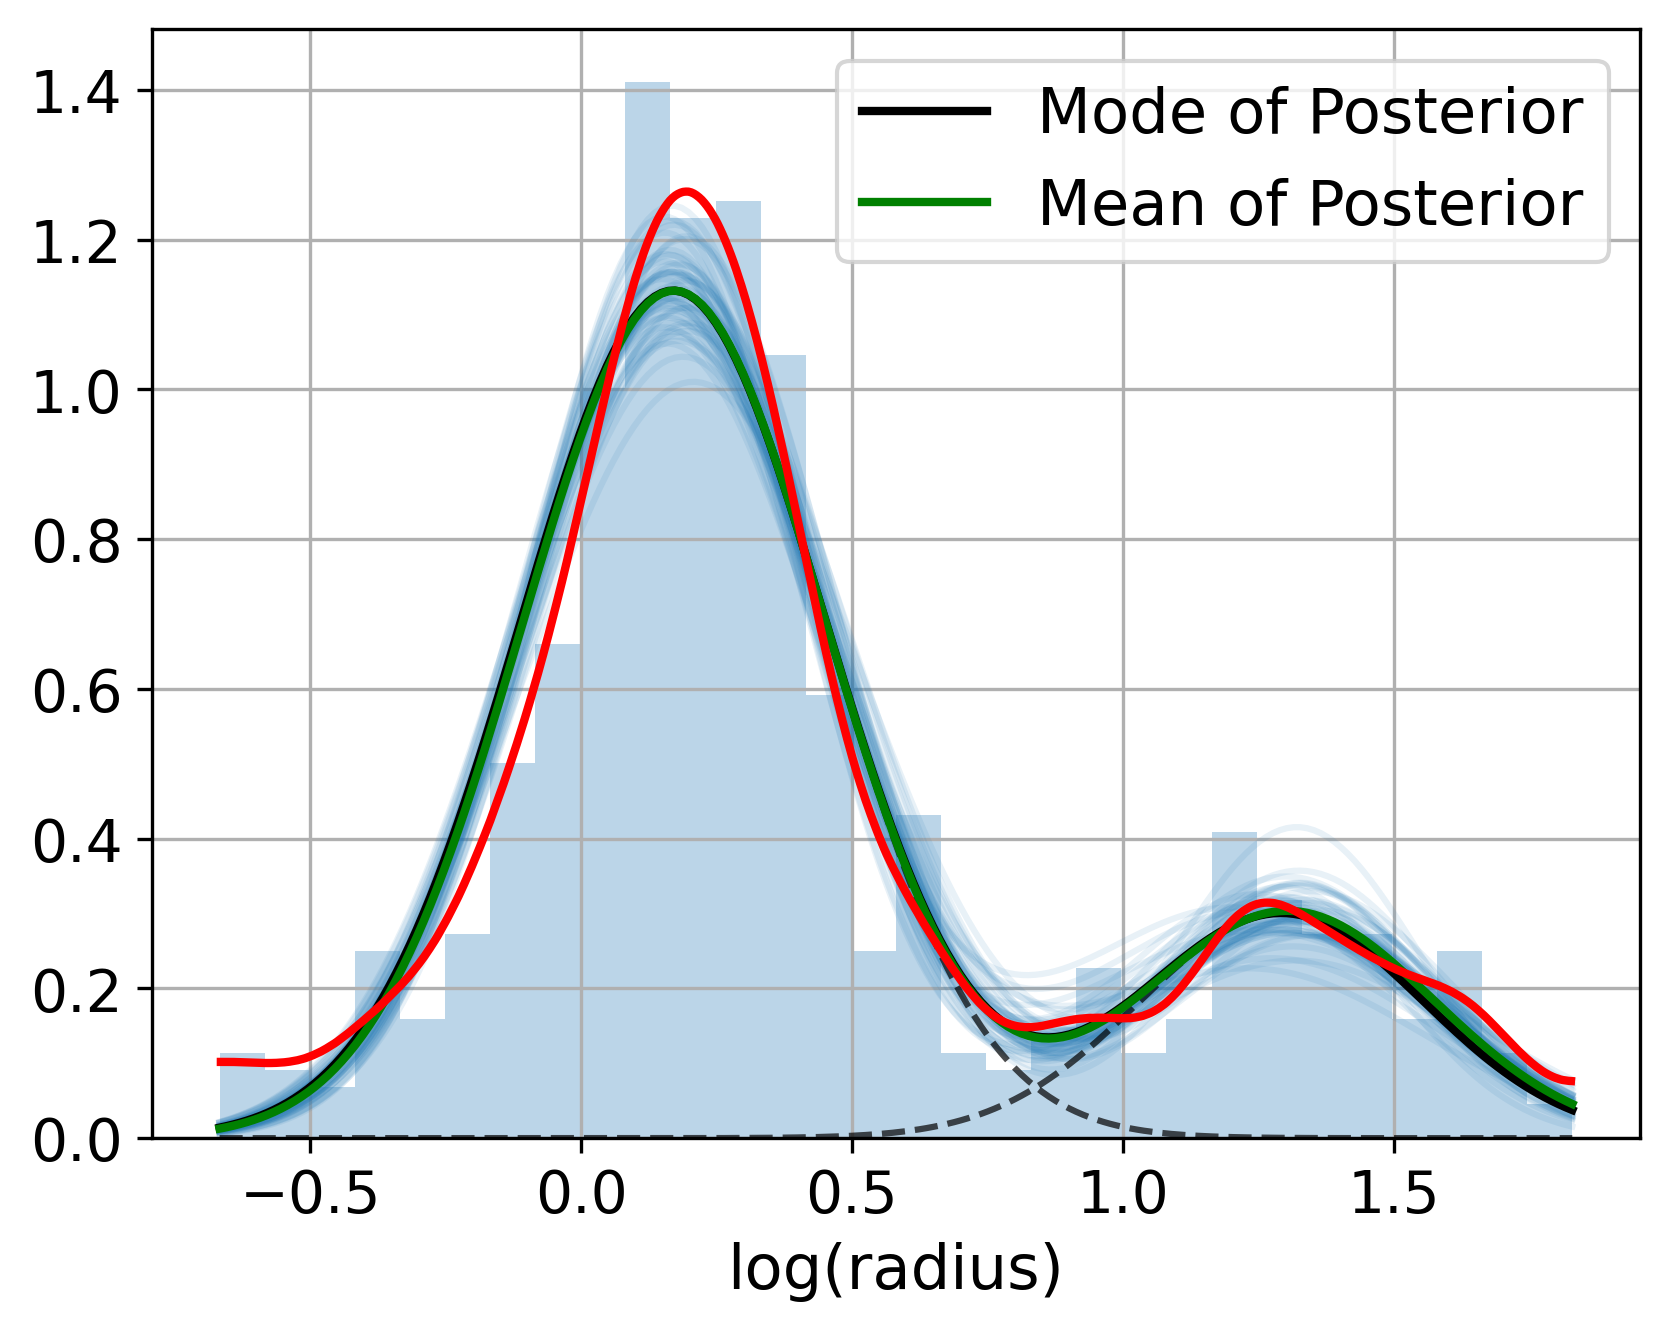

In [125]:
import random
from scipy import stats as st
x = np.linspace(radii_all.min(),radii_all.max(),200)

x_ = np.array([x]*2).T

for i in  range(50):
    i_ = np.random.randint(0,5000)
    means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    dist = stats.norm(means_y,1/np.sqrt(tau_y))
    plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'C0',alpha=0.1)


med_y = st.mode(trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medw_y = st.mode(trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medt_y = st.mode(trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()

dist = stats.norm(med_y,1/np.sqrt(medt_y))
plt.plot(x,np.sum(dist.pdf(x_)*medw_y,1),'k',lw=2,label='Mode of Posterior')
plt.plot(x,dist.pdf(x_)*medw_y,'k--',alpha=0.7)

means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy().mean(1)
tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy().mean(1)
dist = stats.norm(means_y,1/np.sqrt(tau_y))
plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'g',lw=2,label='Mean of Posterior')





az.plot_kde(radii_all,plot_kwargs={'linewidth':2,'color':'r'})
plt.hist(radii_all,bins=30,density = True,alpha = 0.3)
plt.xlabel('log(radius)',fontsize=15)
plt.grid()
plt.legend(fontsize=15)


## Analysis for k=4:

In [126]:
k=4

with pm.Model() as mixture:
    w = pm.Dirichlet('w',a=np.ones(k))
    means = pm.Normal('means1',mu=[0.,1.,2,3],tau=1e-3,shape=(4,))
    tau = pm.Gamma('tau',alpha=0.5, beta=0.5,shape=(4,))
    components = pm.Normal.dist(mu=means,tau=tau, shape=(4,))


    y = pm.Mixture('y', w=w, comp_dists=components, observed=radii_all)

    trace_out = pm.sample(5000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, means1, tau]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 240 seconds.


array([[<AxesSubplot: title={'center': 'means1'}>,
        <AxesSubplot: title={'center': 'means1'}>],
       [<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>],
       [<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

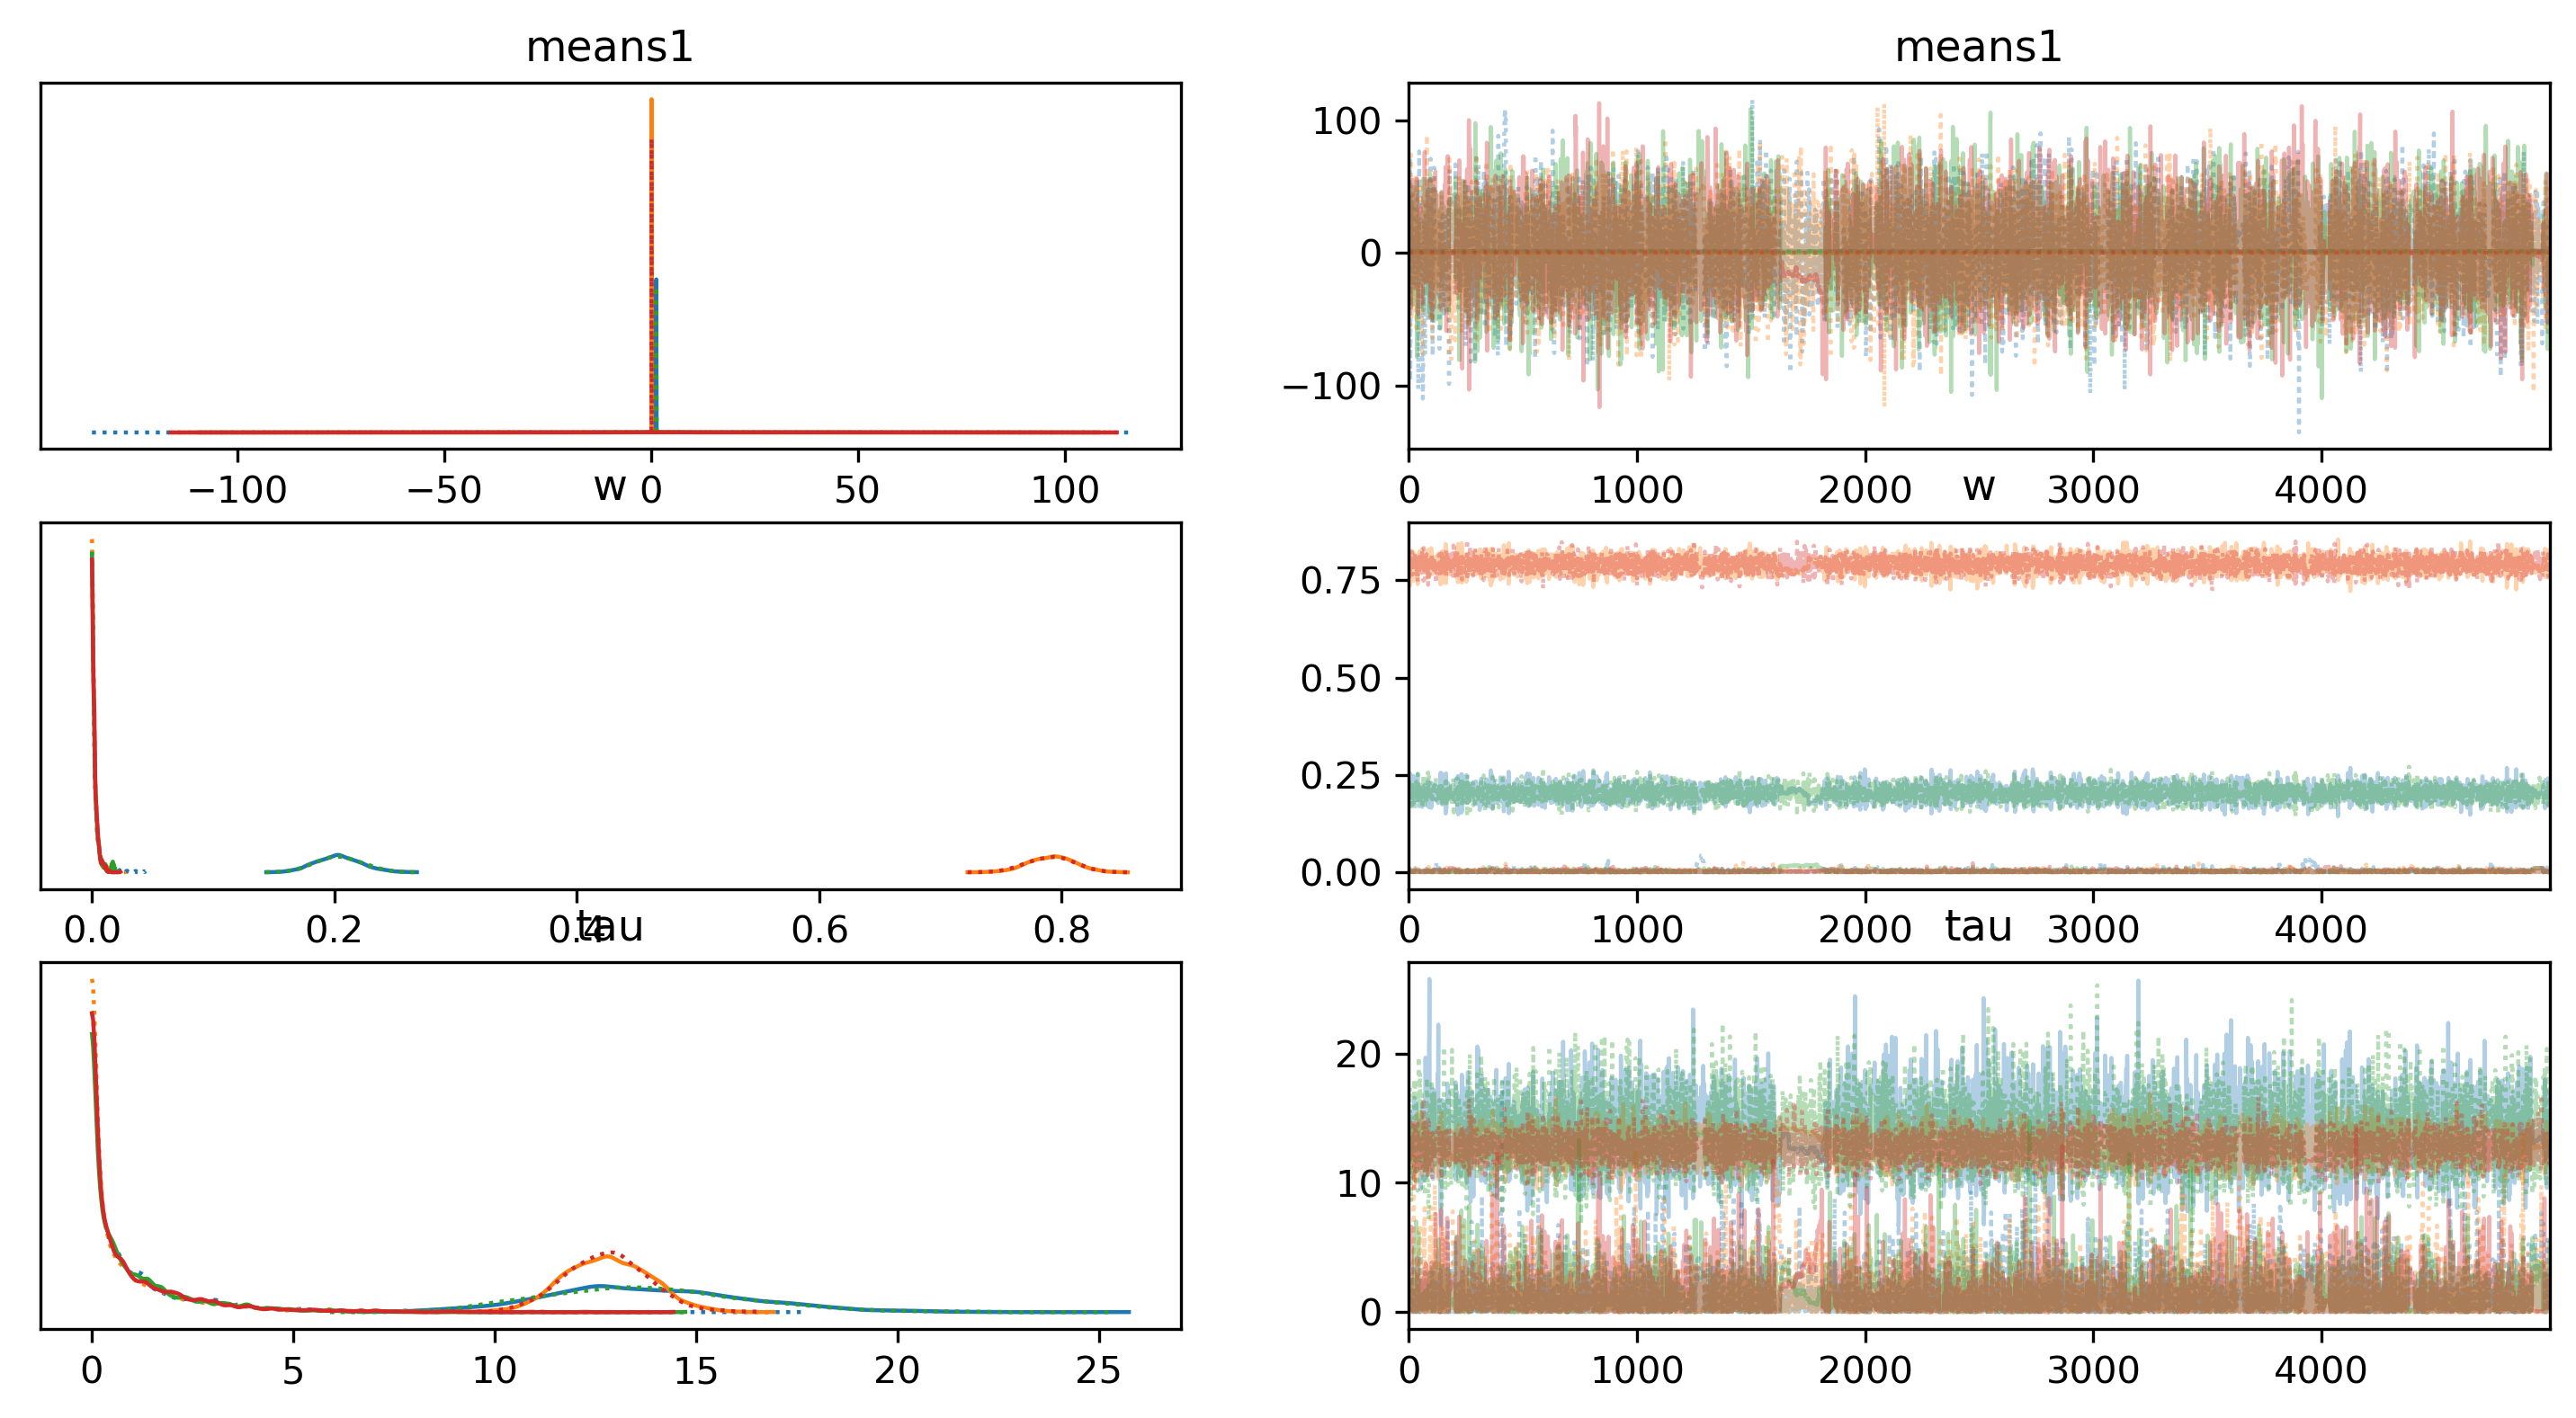

In [127]:
az.plot_trace(trace_out)

In [128]:
az.summary(trace_out)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means1[0]  1.271  21.136 -48.456   46.748      0.295    4.544    4341.0   
means1[1]  0.914  20.824 -44.505   47.790      0.261    4.795    5948.0   
means1[2]  2.017  21.290 -43.565   49.926      0.280    4.736    3890.0   
means1[3]  1.227  21.368 -43.038   52.315      0.369    4.790    2548.0   
w[0]       0.103   0.101   0.000    0.225      0.071    0.060       3.0   
w[1]       0.397   0.395   0.000    0.814      0.279    0.236       3.0   
w[2]       0.103   0.101   0.000    0.227      0.071    0.060       3.0   
w[3]       0.397   0.394   0.000    0.814      0.279    0.236       3.0   
tau[0]     7.449   6.644   0.000   16.819      4.513    3.759       3.0   
tau[1]     6.966   5.991   0.000   14.068      4.144    3.478       3.0   
tau[2]     7.409   6.625   0.000   16.733      4.507    3.756       3.0   
tau[3]     6.942   5.961   0.000   13.945      4.135    3.475       3.0   

           ess_tail  r_hat  
means1[0]      53.0   1.82  
means1[1]      43.0   1.82  
means1[2]      47.0   1.81  
means1[3]      45.0   1.82  
w[0]           49.0   1.83  
w[1]           51.0   1.83  
w[2]           54.0   1.83  
w[3]           47.0   1.83  
tau[0]         51.0   1.82  
tau[1]         61.0   1.83  
tau[2]         64.0   1.82  
tau[3]         58.0   1.83

In [129]:
trace_out

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot: title={'center': 'w\n0'}>,
        <AxesSubplot: title={'center': 'w\n0'}>],
       [<AxesSubplot: title={'center': 'w\n1'}>,
        <AxesSubplot: title={'center': 'w\n1'}>],
       [<AxesSubplot: title={'center': 'w\n2'}>,
        <AxesSubplot: title={'center': 'w\n2'}>],
       [<AxesSubplot: title={'center': 'w\n3'}>,
        <AxesSubplot: title={'center': 'w\n3'}>]], dtype=object)

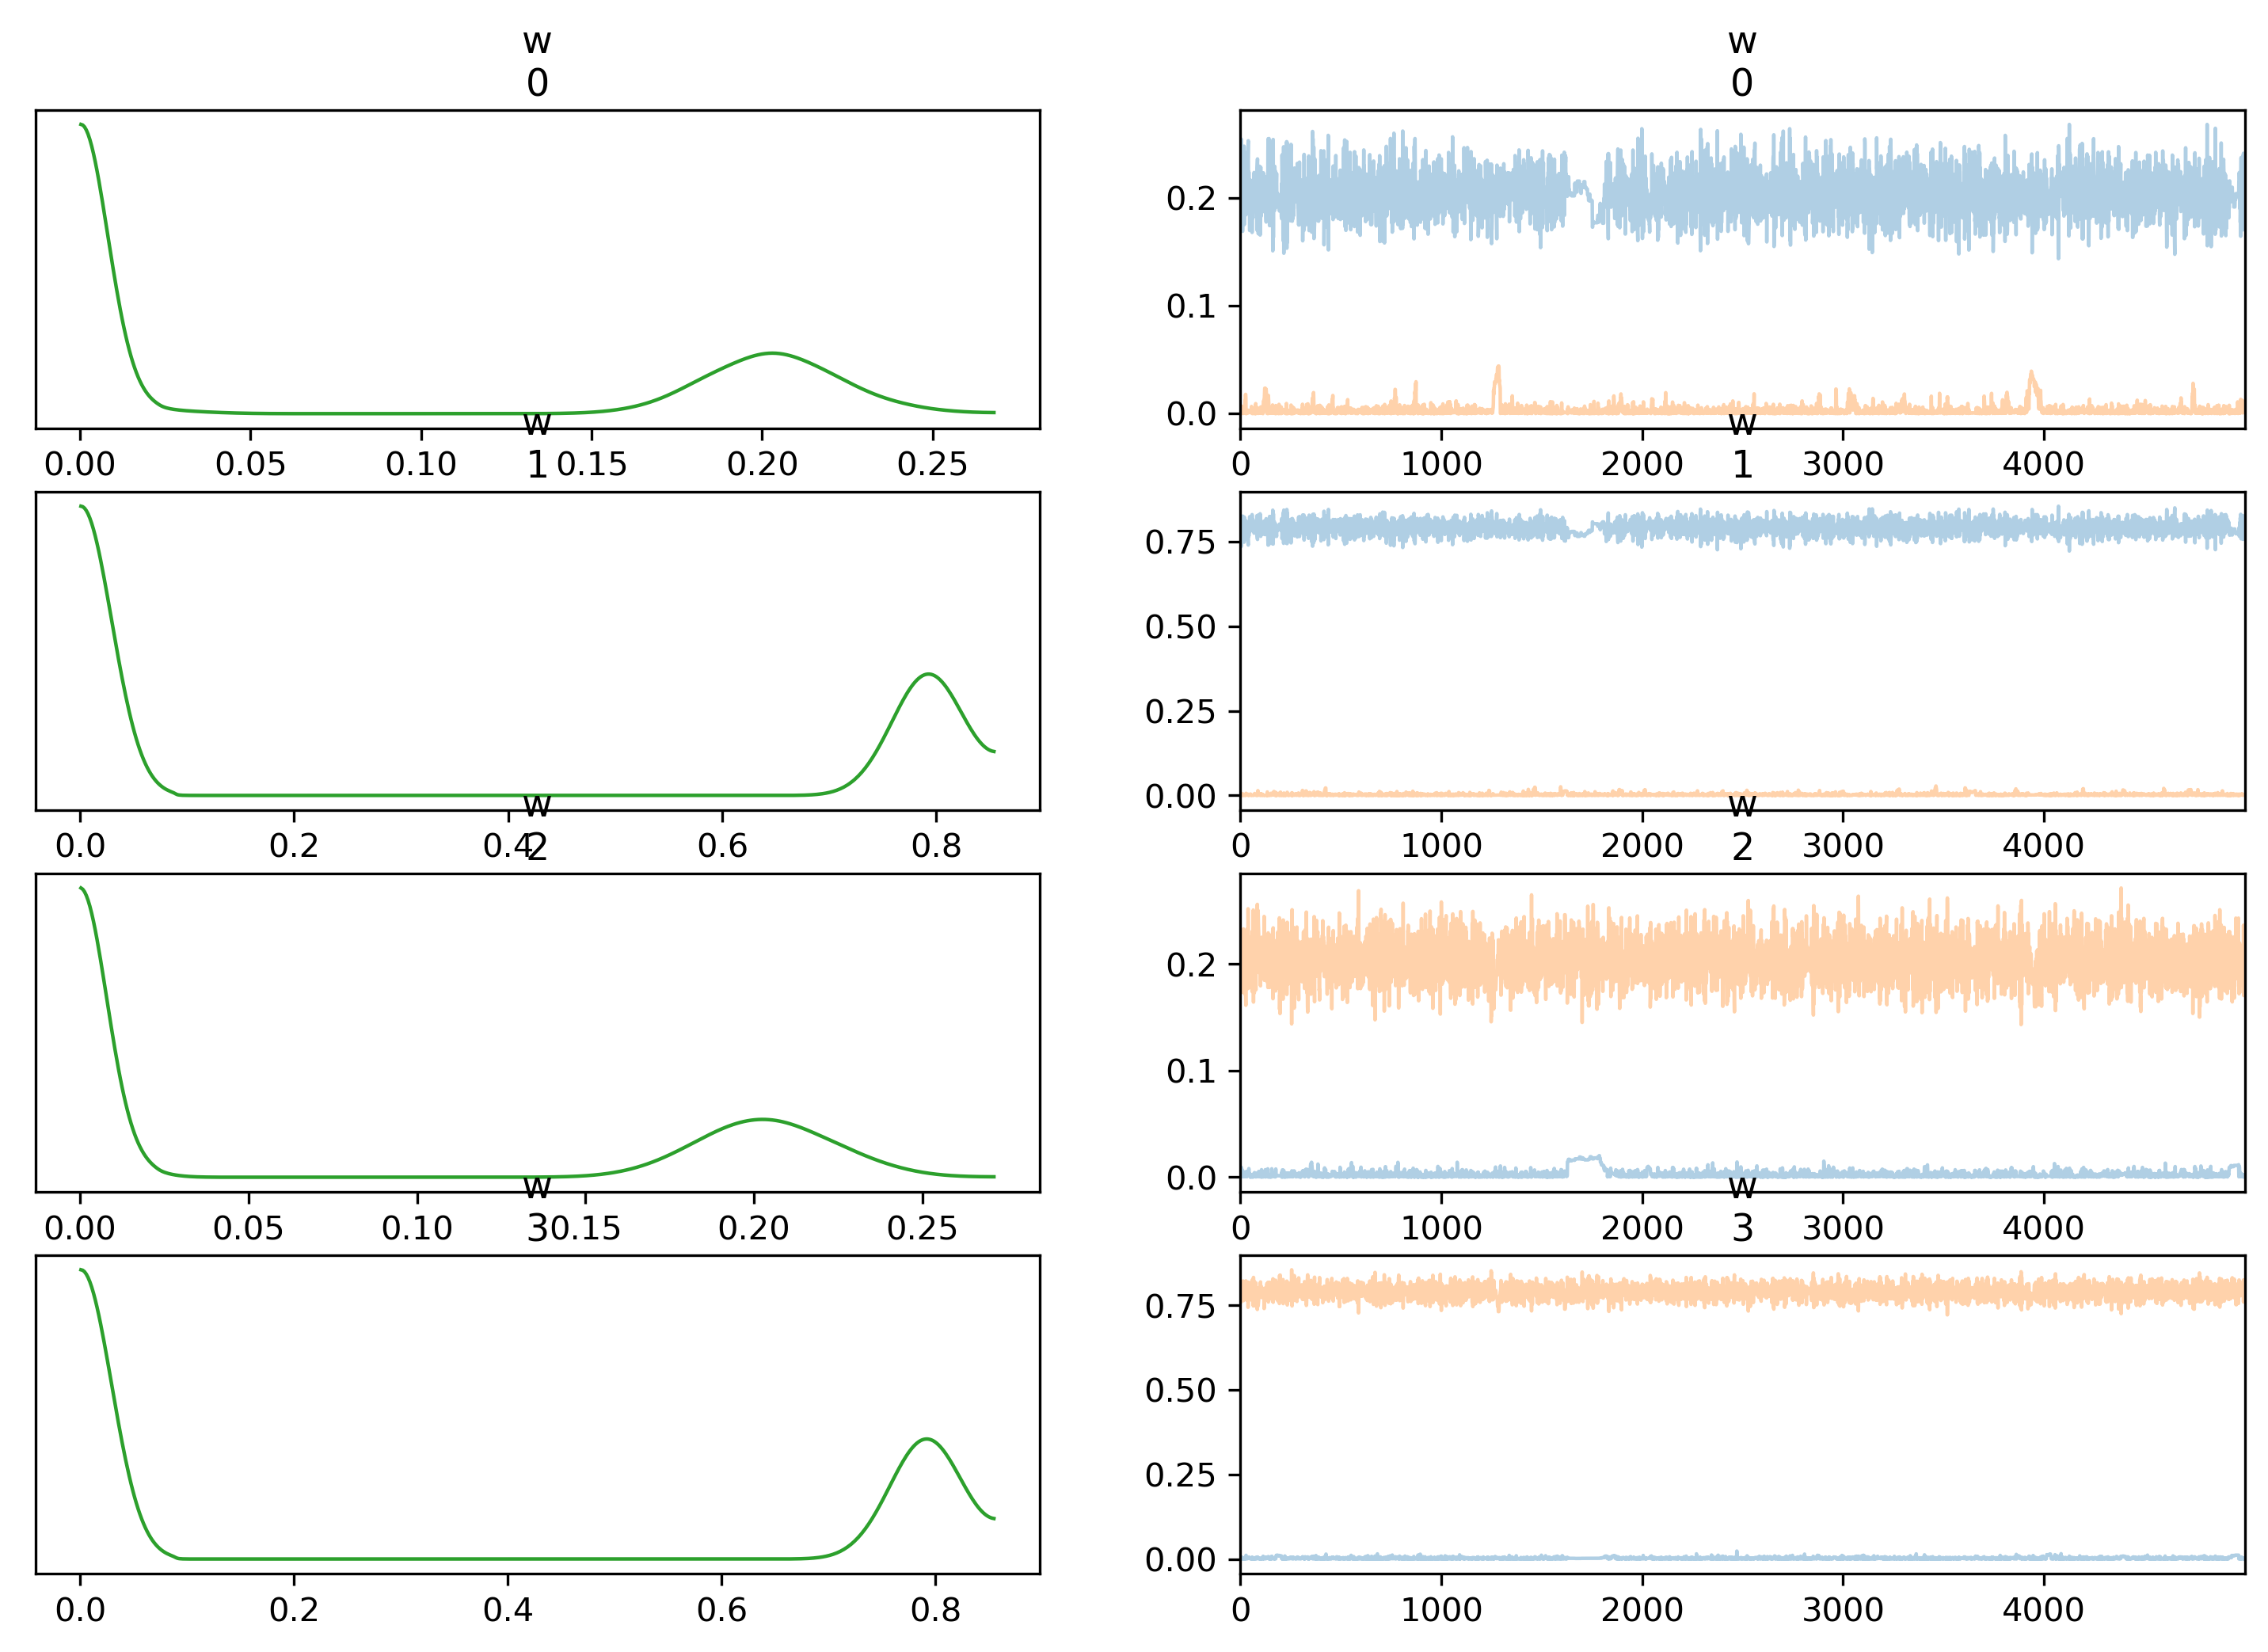

In [130]:
az.plot_trace(trace_out,['w'],combined=True,compact=False)

In [131]:
trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
print(len(trace_out.posterior['means1'].to_numpy()))

2


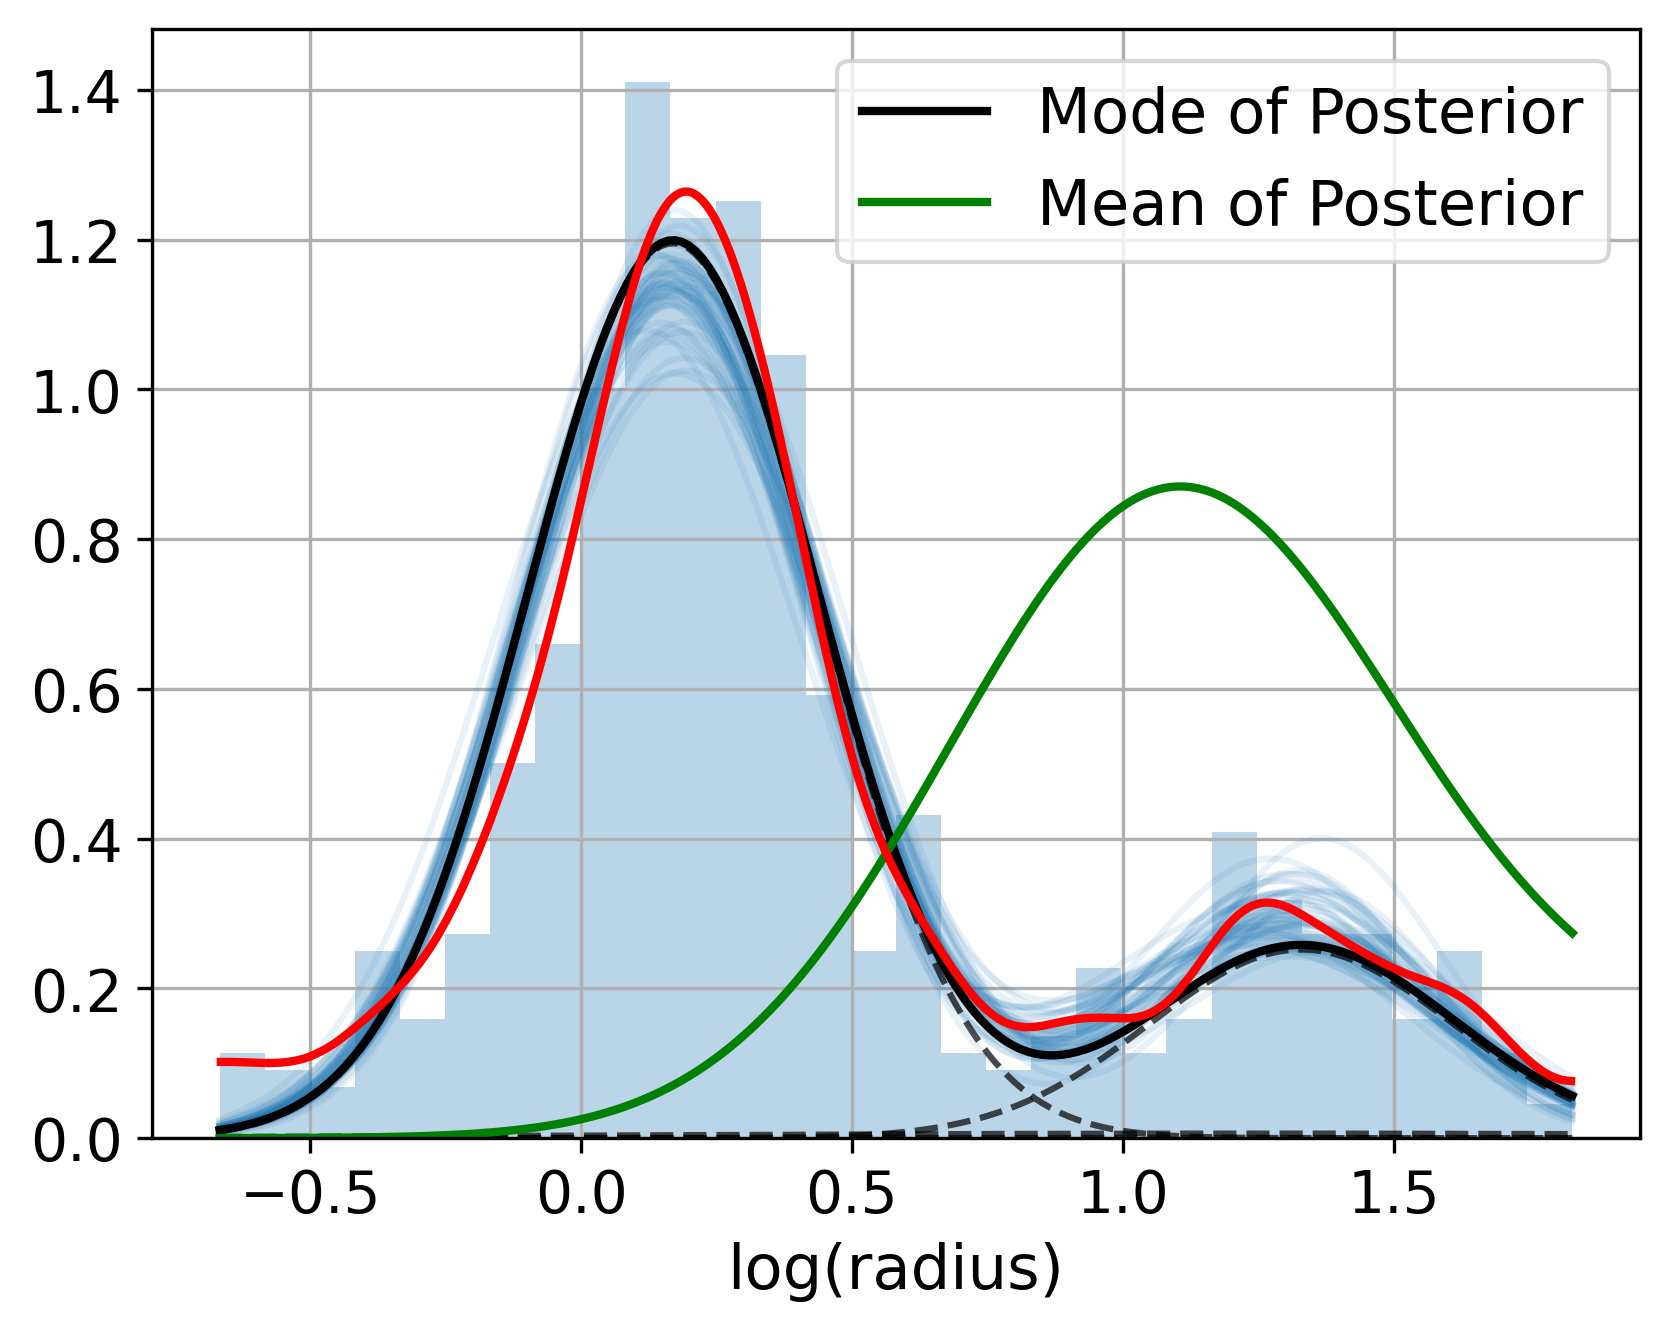

In [132]:
import random
from scipy import stats as st
x = np.linspace(radii_all.min(),radii_all.max(),200)

x_ = np.array([x]*4).T

for i in  range(50):
    i_ = np.random.randint(0,5000)
    means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    dist = stats.norm(means_y,1/np.sqrt(tau_y))
    plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'C0',alpha=0.1)


med_y = st.mode(trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medw_y = st.mode(trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medt_y = st.mode(trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()

dist = stats.norm(med_y,1/np.sqrt(medt_y))
plt.plot(x,np.sum(dist.pdf(x_)*medw_y,1),'k',lw=2,label='Mode of Posterior')
plt.plot(x,dist.pdf(x_)*medw_y,'k--',alpha=0.7)

means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy().mean(1)
tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy().mean(1)
dist = stats.norm(means_y,1/np.sqrt(tau_y))
plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'g',lw=2,label='Mean of Posterior')





az.plot_kde(radii_all,plot_kwargs={'linewidth':2,'color':'r'})
plt.hist(radii_all,bins=30,density = True,alpha = 0.3)
plt.xlabel('log(radius)',fontsize=15)
plt.grid()
plt.legend(fontsize=15)

From this analysis with k=2, 3, and 4, given the strange mean values for the center of the distributions for both k=3 and k=4, as well as the corresponding high standard deviations, it's safe to assume that this distribution can be best modeled using k=2, or that it is bimodal. The subsequent analysis will assume this is true and only look at a bimodal distribution to represent this data.